# Paper figures
This notebook contains code for plotting figures.

### Note
* Most figures in our paper is generated from this notebook.
* Some figures require additional processing. (For example, putting identifying arrows on a square torus) Such figures are saved in "svg" files and are processed in Inkscape. 

### Helpful tips
* <b> plotting barcodes </b>
    * First sort the bars according to increasing birth times and use the function `plot_barcode()`
    * When highlighting certain bars, first plot the barcode (without highlights) using `plot_barcode()` and then use `color_barcode()`
* <b> plotting point clouds and cycle reps </b>
    * Use the function `plot_points()`
    * To plot cycle reps, use `plot_cycle()` or `plot_cycle_on_square_torus()`
* When saving cycle reps in Julia, one must convert the 1-dim array to 2-dim array before saving. Example: `x = hcat(x...)`
* Note that Julia indexing starts at 1, while Python indexing starts at 0. The cycle reps need to be adjusted (by subtracting 1) when plotting.


In [1]:
import h5py
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal, uniform

In [2]:
# specify colors 
color1 = "#2a9d8f"  # dark green. Usually used for plotting points P
color2 = "#fb8500" # dark yellow. Usually used for plotting points Q
pink = "#ff1493"

In [3]:
def plot_barcode(barcode, 
                 lw = 10,
                 color = "slategrey",
                 xleft = None,
                 xright = None,
                 ybottom = None,
                 ytop = None,
                 title = None,
                 titlefontsize = 16,
                 labelsize = None,
                 ax = None):
    """plots barcode"""
    
    ax = ax or plt.gca()
    n_bars = barcode.shape[0]
    
    # find maximum death time (excluding Inf, if it exists)
    death_times = barcode[:,1]
    death_max = np.nanmax(death_times[death_times != np.inf])

    # plot bars
    for i in range(n_bars):
        left = barcode[i,0]
        right = barcode[i,1]
        
        # adjust the right end point (if inf)
        if right == np.inf:
            right = death_max * 1.2
        
        # specific kwargs
        ax.hlines(i, left, right, color = color, lw = lw)
        
    # set xlim  
    if xleft != None:
        ax.set_xlim(left = xleft)
    if xright != None:
        ax.set_xlim(right = xright)    
    if labelsize != None:
        ax.tick_params(axis='x', labelsize=labelsize)
        
    # set ylim
    if ytop != None:
        ax.set_ylim(top = ytop)
    if ytop != None:
        ax.set_ylim(bottom = ybottom)
    if (ytop == None) & (ybottom == None):    
        ax.set_ylim(bottom = -0.5, top = n_bars - 0.5)
        
    ax.set_yticks([])
    
    if title != None:
        ax.set_title(title, fontsize = titlefontsize)
  
    return ax

def color_barcode(ax, barcode, bar_idx, color, lw = 10, epsilon = None):
    """given a barcode plot, color specific bars. 
    This function should be called after calling `plot_barcode()`
    
    Parameters
    ----------
    ax: (matplotlib axes object)
    barcode: (array)
    bar_idx: (list) of bars to color
    color: (str) color
    epsilon: (float) if provided, only color the portion of the bar on the right side of epsilon. 
    
    Returns
    -------
    ax
    """
    # given a plot of a barcode, color specific bars
    
    # find maximum death time (excluding Inf, if it exists)
    death_times = barcode[:,1]
    death_max = np.nanmax(death_times[death_times != np.inf])
    
    for i in bar_idx:
        left = barcode[i,0]
        right = barcode[i,1]
        
        # adjust the left end point (if epsilon is provided)
        if epsilon != None:
            left = max(left, epsilon)
        
        # adjust the right end point (if inf)
        if right == np.inf:
            right = death_max * 1.2
        
        
        ax.hlines(i, left, right, color = color, lw = lw)
    return ax
    

In [4]:
def plot_points(P, 
                Q, 
                ax = None, 
                P_color = color1, 
                Q_color = color2,
                P_size = 100,
                Q_size = 100, 
                P_alpha = 1,
                Q_alpha = 1,
                P_label = "P",
                Q_label = "Q",
                P_marker = "o",
                Q_marker = "X",
                legend_size = 18,
                legend = True,
                legend_loc = "lower left"):
    """Plots the points on a 2D-square 
    
    key parameters
    --------------
    P: (array) of size (n, 2) or (n,3), where n is the number of points.
    Q: (array) of size (n, 2) or (n,3)
    
    Returns
    -------
    axes object for plotting
    """
    
    # create axes
    if ax is None:
        ax = plt.gca()
    
    # plot points
    ax.scatter(P[:,0], P[:,1], s = P_size, c = P_color, alpha = P_alpha, label = P_label, marker = P_marker, edgecolors = "black")
    ax.scatter(Q[:,0], Q[:,1], s = Q_size, c = Q_color, alpha = Q_alpha, label = Q_label, marker= Q_marker, edgecolors = "black")

    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    if legend == True:
        ax.legend(loc = legend_loc, fontsize = legend_size)
    return ax


def plot_cycle(cycle, ax, points, cycle_color = "#ff1493", linewidth = 4):
    """plots cycle on a 2D square
    This function should be called after calling the `plot_points()` function.
    
    Parameters
    ----------
    cycle: (array) of shape (m, 2). cycle[i] = [x,y] indicates the presence of a 1-simplex [x,y]
    ax: (Axes object) output of the function `plot_square_torus()`
    points: (array) of shape (n, 2). Coordinates of the points on which the cycle lives.
    """
    # get theta, phi values
    x = points[:,0]
    y = points[:,1]
    
    # plot cycle 
    for simplex in cycle:
        v1, v2 = simplex
        v1_x, v1_y = x[v1-1], y[v1-1] # -1 is necessary because Julia indexing starts at 1
        v2_x, v2_y = x[v2-1], y[v2-1]

        ax.plot([v1_x, v2_x], [v1_y, v2_y], c = cycle_color, lw = linewidth)
    return ax

def plot_cycle_on_square_torus(cycle, ax, points, cycle_color = "#ff1493", linewidth = 4):
    """plots cycle on a square torus.
    This function should be called after calling the `plot_points()` function.
    
    Parameters
    ----------
    cycle: (array) of shape (m, 2). cycle[i] = [x,y] indicates the presence of a 1-simplex [x,y]
    ax: (Axes object) output of the function `plot_points()`
    points: (array) of shape (n, 2). Coordinates of the points on which the cycle lives.
    """
    # get theta, phi values
    theta = points[:,0]
    phi = points[:,1]
    
    # plot cycle 
    for simplex in cycle:
        v1, v2 = simplex
        v1_theta, v1_phi = theta[v1-1], phi[v1-1] # -1 is necessary because Julia indexing starts at 1
        v2_theta, v2_phi = theta[v2-1], phi[v2-1]

        # if the simplex doesn't cross the square boundary, plot it:
        if (abs(v1_theta - v2_theta) <= 2 ) and (abs(v1_phi - v2_phi) <= 2):
            ax.plot([v1_theta, v2_theta], [v1_phi, v2_phi], c = cycle_color, lw = linewidth)
    return ax

# 1. Problem statement 
* I drew this figure by hand on Inkscape. 
* See `problem_statement_figure.svg`

# 2. Two circles (different distributions)
From `examples/two_circles`  

### (a) plot the two distributions on annulus

In [14]:
def circle_density(x, y, mean, cov):
    """computes density of a circular distribution in 2D.
    
    Parameters
    ----------
    x: (float) x-coordinate
    y: (float) y-coordinate
    mean: (float) mean of the normal distribution for distance from (0,0)
    cov: (float) covariance of the normal distribution for distance from (0,0)
    
    Returns
    -------
    density value
    
    """
    angle = math.atan2(y, x)
    distance = math.sqrt(x**2 + y**2)
    
    angle_pdf = uniform.pdf(angle, loc = - math.pi, scale = 2 * math.pi)
    distance_pdf = multivariate_normal.pdf(distance, mean = mean, cov = cov)
    
    return angle_pdf * distance_pdf
    

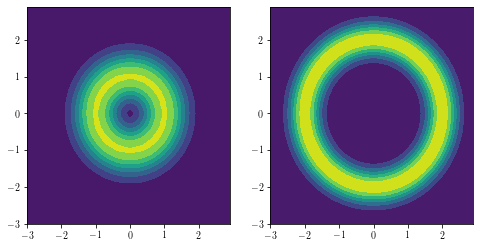

In [10]:
# 2D density chart for the two circles
xx, yy = np.mgrid[-3:3:0.1, -3:3:0.1]
density_v = np.vectorize(circle_density) 
small = density_v(xx, yy, 1, 0.2)
large = density_v(xx, yy, 2, 0.1)

fig, ax = plt.subplots(ncols = 2, figsize = (8, 4))
ax[0].contourf(xx, yy, small)
ax[1].contourf(xx, yy, large)
plt.show()

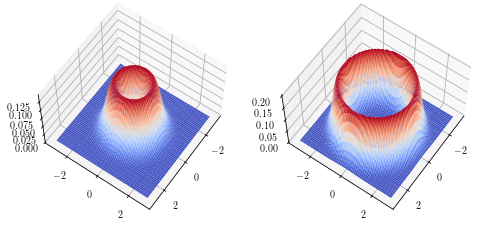

In [11]:
# plot density in 3D
xx, yy = np.mgrid[-3:3:0.1, -3:3:0.1]
density_v = np.vectorize(circle_density) 
small = density_v(xx, yy, 1, 0.2)
large = density_v(xx, yy, 2, 0.1)

fig = plt.figure(figsize=(8, 4))
# small circle
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xx, yy, small, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.view_init(60, 35)

# large circle
ax = fig.add_subplot(1, 2, 2, projection = '3d')
surf = ax.plot_surface(xx, yy, large, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.view_init(60, 35)
#plt.savefig("figures/two_circles_distributions.pdf")
plt.show()

## (b) Plot points

In [12]:
# load points
f = h5py.File("data/two_circles/two_circles.jld", "r")

P = np.array(f["points"][()]).transpose()
n_small = f["n_small"][()]
n_large = f["n_large"][()]

small = P[:n_small,:]
large = P[n_small:, :]

f.close()

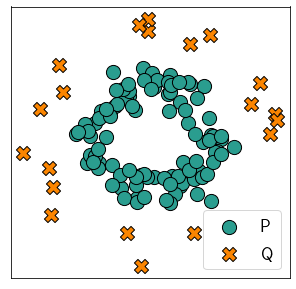

In [13]:
# plot points
size = 200
plt.figure(figsize = (5,5))
plot_points(small, large, P_size = size, Q_size = size, legend_loc = "lower right")

#plt.savefig("figures/two_circles.pdf")
plt.show()

## (c) Plot the three barcodes

In [14]:
# load barcode
f = h5py.File("data/two_circles/two_circles_barcodes.jld", "r")
union_barcode = np.array(f["union"][()]).transpose()
small_barcode = np.array(f["small"][()]).transpose()
large_barcode = np.array(f["large"][()]).transpose()
f.close()

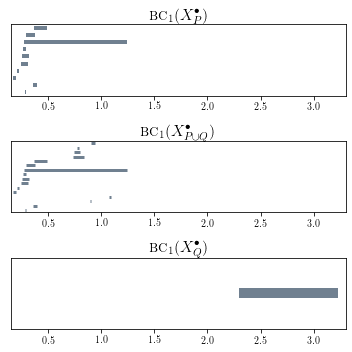

In [15]:
# plot three barcodes
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (5, 5))

# specify keyword arguments
xleft = 0.15
xright = 3.3

plot_barcode(small_barcode, ax = ax0, xleft = xleft, xright = xright, lw = 4,  title = r'$\textsc{bc}_1(X^\bullet_P)$')
plot_barcode(union_barcode, ax = ax1, xleft = xleft, xright = xright, lw = 3, title = r'$\textsc{bc}_1(X^\bullet_{P \cup Q})$')
plot_barcode(large_barcode, ax = ax2, xleft = xleft, xright = xright, title = r'$\textsc{bc}_1(X^\bullet_Q)$')
fig.tight_layout() 
#plt.savefig("figures/two_circles_barcode.pdf")
plt.show()

# 3. Same distributions
From `examples/data/annulus_same_distribution`

## (a) plot points

In [53]:
# load points
with h5py.File("data/annulus_same_distribution/data.jld", "r") as f:
    P = f["P"][()].transpose()
    Q = f["Q"][()].transpose()

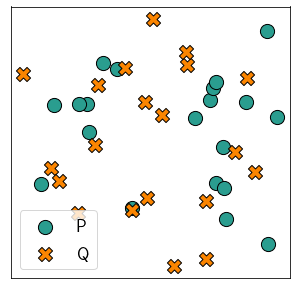

In [54]:
# plot points
size = 200
plt.figure(figsize = (5,5))
plot_points(P, Q, P_size = size, Q_size = size)

#plt.savefig("figures/same_distributions.pdf")
plt.show()

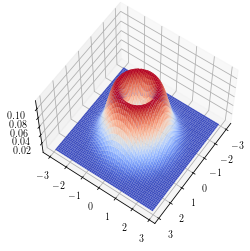

In [55]:
# plot density in 3D
xx, yy = np.mgrid[-3:3:0.1, -3:3:0.1]
density_v = np.vectorize(circle_density) 
annulus = density_v(xx, yy, 1, 0.3)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(xx, yy, annulus, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.view_init(60, 35) # view angle

#plt.savefig("figures/same_distributions_pdf.pdf")
plt.show()

## (b) plot induced matching results

In [54]:
with h5py.File("data/annulus_same_distribution/induced_matching.jld", "r") as f:
    barcode_P = f["barcode_P"][()].transpose()
    barcode_union = f["barcode_union"][()].transpose()
    barcode_Q = f["barcode_Q"][()].transpose()
    int_Q = f["int_Q"][()].tolist()
    int_PQ = f["int_PQ"][()].tolist()

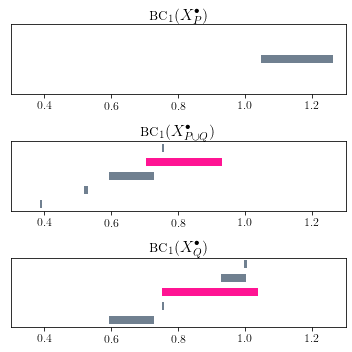

In [57]:
# plot barcodes
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (5, 5))

# specify keyword arguments
xleft = 0.3
xright = 1.3
labelsize = 12 # x-tick label size
highlight_color = "#ff1493"

### plot barcode_P ###
plot_barcode(barcode_P, ax = ax0, xleft = xleft, xright = xright, labelsize = labelsize, lw = 8, title = r'$\textsc{bc}_1(X^\bullet_P)$',)

### plot barcode_union ###
# sort bars & plot
index = np.argsort(barcode_union[:,0]).tolist()
plot_barcode(barcode_union[index,:], ax = ax1, xleft = xleft, xright = xright, labelsize = labelsize, lw = 8, title = r'$\textsc{bc}_1(X^\bullet_{P \cup Q})$',)
# highlight the matched bar
bar_idx = [index.index(i-1) for i in int_PQ]
color_barcode(ax1, barcode_union[index,:], bar_idx = bar_idx, color = highlight_color, lw = 8)

#### plot barcode_Q ###
index = np.argsort(barcode_Q[:,0]).tolist()
plot_barcode(barcode_Q[index,:], ax = ax2, xleft = xleft, xright = xright, labelsize = labelsize, lw = 8, title = r'$\textsc{bc}_1(X^\bullet_Q)$',)
# highlight the matched bar
bar_idx = [index.index(i-1) for i in int_Q]
color_barcode(ax2, barcode_Q[index,:], bar_idx = bar_idx, color = highlight_color, lw = 8)

fig.tight_layout() 
#plt.savefig("figures/same_distributions_union_barcode.pdf")
plt.show()

## (c) plot cycle reps

In [58]:
# load data
with h5py.File("data/annulus_same_distribution/classrep.jld", "r") as f:
    class_P = f["class_P"][()]
    class_union = f["class_union"][()]
    class_Q = f["class_Q"][()]

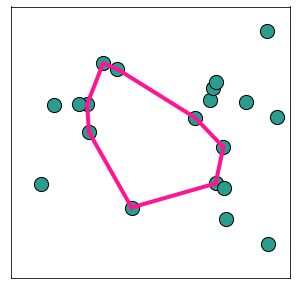

In [60]:
# plot class_P
fig, ax = plt.subplots(figsize = (5,5))
size = 200

# plot points P
plot_points(P, Q, P_size = size, Q_alpha = 0, ax = ax, legend = False) # set Q_alpha = 0 to only show P
# plot class_P
plot_cycle(class_P, ax, P)

#plt.savefig("figures/same_distributions_classrep_P.pdf")
plt.show()

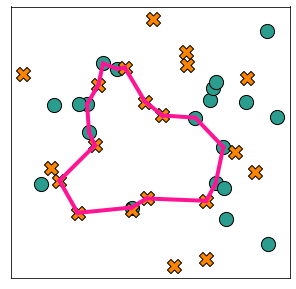

In [63]:
# plot class_union
fig, ax = plt.subplots(figsize = (5,5))
size = 200

# plot points P, Q
plot_points(P, Q, P_size = size, Q_size = size, ax = ax, legend = False)

# plot class in union
plot_cycle(class_union, ax, np.concatenate((P,Q)))

#plt.savefig("figures/same_distributions_classrep_union.pdf")
plt.show()

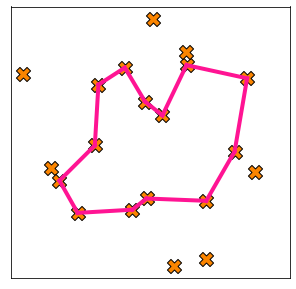

In [64]:
# plot class_Q
fig, ax = plt.subplots(figsize = (5,5))
size = 200

# plot points Q
plot_points(P, Q, Q_size = size, ax = ax, legend = False, P_alpha = 0) # set P_alpha = 0 to only show Q

# plot class_Q
plot_cycle(class_Q, ax, Q)

#plt.savefig("figures/same_distributions_classrep_Q.pdf")
plt.show()

## (d) plot the analogous bars result

In [36]:
# load data
with h5py.File("data/annulus_same_distribution/analogous_bars.jld", "r") as f:
    barcode_P = f["barcode_P"][()].transpose()
    barcode_W_PQ = f["barcode_W_PQ"][()].transpose()
    barcode_W_QP = f["barcode_W_QP"][()].transpose()
    barcode_Q = f["barcode_Q"][()].transpose()
    bar_P = f["bar_P"][()].tolist()
    bar_W_PQ = f["bar_W_PQ"][()].tolist()
    bar_W_QP = f["bar_W_QP"][()].tolist()
    bar_Q = f["bar_Q"][()].tolist()
    

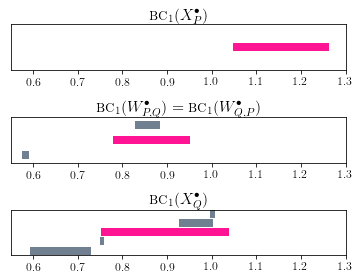

In [66]:
### plot four barcodes (VR and Witness)

# plot barcodes
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (5, 4))
xleft = 0.55
xright = 1.3
labelsize = 12

### plot barcode_P ###
index = np.argsort(barcode_P[:,0]).tolist()
plot_barcode(barcode_P[index,:], ax = ax0, xleft = xleft, xright = xright, labelsize = labelsize, lw = 8, title = r'$\textsc{bc}_1(X^\bullet_P)$')
# highlight selected bar
bar_idx = [index.index(i-1) for i in bar_P]
color_barcode(ax0, barcode_P[index,:], bar_idx = bar_idx, color = "#ff1493", lw = 8)

### plot witness barcode ###
index = np.argsort(barcode_W_PQ[:,0]).tolist()
plot_barcode(barcode_W_PQ[index,:], ax = ax1, xleft = xleft, xright = xright, labelsize = labelsize, lw = 8, title = r'$\textsc{bc}_1(W^\bullet_{P, Q}) = \textsc{bc}_1(W^\bullet_{Q, P})$')
# highlight selected bar
bar_idx = [index.index(i-1) for i in bar_W_PQ]
color_barcode(ax1, barcode_W_PQ[index,:], bar_idx = bar_idx, color = "#ff1493", lw = 8)


### plot barcode_Q ###
index = np.argsort(barcode_Q[:,0]).tolist()
plot_barcode(barcode_Q[index,:], ax = ax2, xleft = xleft, xright = xright, labelsize = labelsize, lw = 8, title = r'$\textsc{bc}_1(X^\bullet_Q)$')
# highlight selected bar
bar_idx = [index.index(i-1) for i in bar_Q]
color_barcode(ax2, barcode_Q[index,:], bar_idx = bar_idx, color = "#ff1493", lw = 8)

fig.tight_layout() 
#plt.savefig("figures/same_distributions_four_barcodes.pdf")
plt.show()

# 2&3 combined: three point clouds from annulus
From `examples/data/annulus_three_pointclouds`

In [5]:
# load points
with h5py.File("data/annulus_three_pointclouds/three_point_clouds.jld", "r") as f:
    P = np.array(f["P"][()]).transpose()
    Q = np.array(f["Q"][()]).transpose()
    R = np.array(f["R"][()]).transpose()
    
# load barcodes
with h5py.File("data/annulus_three_pointclouds/annulus_barcodes.jld", "r") as f:
    barcode_P = f["barcode_P"][()].transpose()
    barcode_PQ = f["barcode_PQ"][()].transpose()
    barcode_Q = f["barcode_Q"][()].transpose()
    barcode_QR = f["barcode_QR"][()].transpose()
    barcode_R = f["barcode_R"][()].transpose()
    barcode_W_QR = f["barcode_W_QR"][()].transpose()
    barcode_W_RQ = f["barcode_W_RQ"][()].transpose()
    int_QR = f["int_QR"][()].tolist()
    int_R = f["int_R"][()].tolist()
    bar_Q = f["bar_Q"][()].tolist()
    bar_W_QR = f["bar_W_QR"][()].tolist()
    bar_W_RQ = f["bar_W_RQ"][()].tolist()
    bar_R = f["bar_R"][()].tolist()

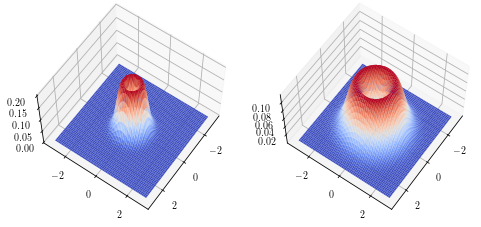

In [110]:
### plot density 
# plot density in 3D
xx, yy = np.mgrid[-3:3:0.1, -3:3:0.1]
density_v = np.vectorize(circle_density) 
small = density_v(xx, yy, 0.5, 0.1)
large = density_v(xx, yy, 1, 0.3)

fig = plt.figure(figsize=(8, 4))
# small circle
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xx, yy, small, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.view_init(60, 35)

# large circle
ax = fig.add_subplot(1, 2, 2, projection = '3d')
surf = ax.plot_surface(xx, yy, large, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.view_init(60, 35)
#plt.savefig("figures/annulus_distributions.pdf")
plt.show()

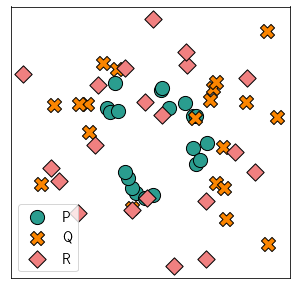

In [117]:
# plot points
size = 200
plt.figure(figsize = (5,5))
ax = plot_points(P, Q, P_size = size, Q_size = size)
ax.scatter(R[:,0], R[:,1], s = 150, c = "lightcoral", label = "R", marker = "D", edgecolors = "black")
ax.legend(loc = "lower left", fontsize = 14)
#plt.savefig("figures/annulus_three_point_clouds.pdf")
plt.show()

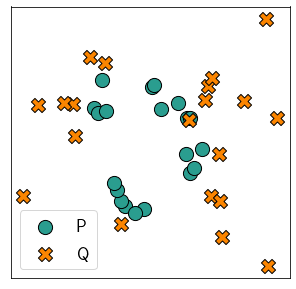

In [118]:
# plot points
size = 200
plt.figure(figsize = (5,5))
plot_points(P, Q, P_size = size, Q_size = size)

#plt.savefig("figures/annulus_PQ.pdf")
plt.show()

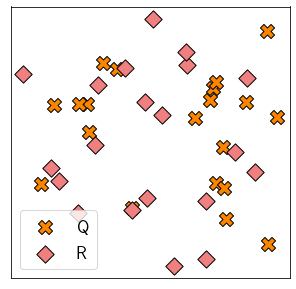

In [119]:
# plot points
size = 200
plt.figure(figsize = (5,5))
plot_points(Q, R, P_size = size, P_label = "Q", P_color = color2,P_marker = "X",
            Q_size = 150, Q_label = "R", Q_color = "lightcoral", Q_marker = "D")

#plt.savefig("figures/annulus_QR.pdf")
plt.show()

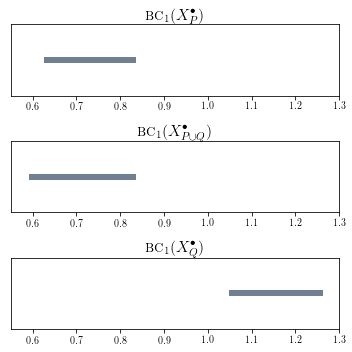

In [6]:
# plot three barcodes between P & Q
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (5, 5))

# specify keyword arguments
xleft = 0.55
xright = 1.3

# sort barcodes by birth time
index_P = np.argsort(barcode_P[:,0]).tolist()
index_PQ = np.argsort(barcode_PQ[:,0]).tolist()

plot_barcode(barcode_P[index_P,:], ax = ax0, xleft = xleft, xright = xright, lw = 6,  title = r'$\textsc{bc}_1(X^\bullet_P)$')
plot_barcode(barcode_PQ[index_PQ,:], ax = ax1, xleft = xleft, xright = xright, lw = 6, title = r'$\textsc{bc}_1(X^\bullet_{P \cup Q})$')
plot_barcode(barcode_Q, ax = ax2, xleft = xleft, xright = xright, lw = 6, title = r'$\textsc{bc}_1(X^\bullet_Q)$')
fig.tight_layout() 
#plt.savefig("figures/annulus_PQ.pdf")
plt.show()

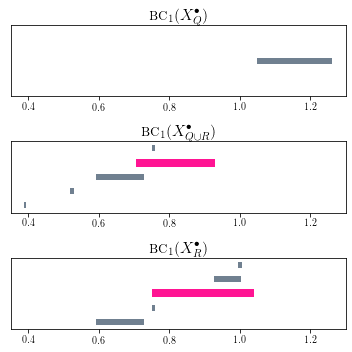

In [8]:
# plot three barcodes between P & Q
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (5, 5))

# specify keyword arguments
xleft = 0.35
xright = 1.3
highlight_color = "#ff1493"

# plot barcode_Q
plot_barcode(barcode_Q, ax = ax0, xleft = xleft, xright = xright, lw = 6,  title = r'$\textsc{bc}_1(X^\bullet_Q)$')

# plot barcode_QR
index_QR = np.argsort(barcode_QR[:,0]).tolist()
plot_barcode(barcode_QR[index_QR,:], ax = ax1, xleft = xleft, xright = xright, lw = 6, title = r'$\textsc{bc}_1(X^\bullet_{Q \cup R})$')
# highlight the matched bar
bar_idx = [index_QR.index(i-1) for i in int_QR]
color_barcode(ax1, barcode_QR[index_QR,:], bar_idx = bar_idx, color = highlight_color, lw = 8)

# plot barcode_R
index_R = np.argsort(barcode_R[:,0]).tolist()
plot_barcode(barcode_R[index_R, :], ax = ax2, xleft = xleft, xright = xright, lw = 6,title = r'$\textsc{bc}_1(X^\bullet_R)$')
# highlight the matched bar
bar_idx = [index_R.index(i-1) for i in int_R]
color_barcode(ax2, barcode_R[index_R,:], bar_idx = bar_idx, color = highlight_color, lw = 8)
fig.tight_layout() 
#plt.savefig("figures/annulus_barcodes_QR.pdf")
plt.show()

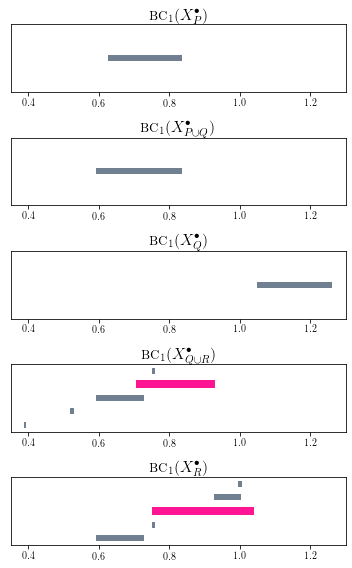

In [15]:
### plot the 5 barcodes (P, Q, R)


fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows = 5, figsize = (5, 8))

# specify keyword arguments
xleft = 0.35
xright = 1.3

# sort barcodes by birth time
index_P = np.argsort(barcode_P[:,0]).tolist()
index_PQ = np.argsort(barcode_PQ[:,0]).tolist()

plot_barcode(barcode_P[index_P,:], ax = ax0, xleft = xleft, xright = xright, lw = 6,  title = r'$\textsc{bc}_1(X^\bullet_P)$')
plot_barcode(barcode_PQ[index_PQ,:], ax = ax1, xleft = xleft, xright = xright, lw = 6, title = r'$\textsc{bc}_1(X^\bullet_{P \cup Q})$')
plot_barcode(barcode_Q, ax = ax2, xleft = xleft, xright = xright, lw = 6, title = r'$\textsc{bc}_1(X^\bullet_Q)$')
highlight_color = "#ff1493"

# plot barcode_QR
index_QR = np.argsort(barcode_QR[:,0]).tolist()
plot_barcode(barcode_QR[index_QR,:], ax = ax3, xleft = xleft, xright = xright, lw = 6, title = r'$\textsc{bc}_1(X^\bullet_{Q \cup R})$')
# highlight the matched bar
bar_idx = [index_QR.index(i-1) for i in int_QR]
color_barcode(ax3, barcode_QR[index_QR,:], bar_idx = bar_idx, color = highlight_color, lw = 8)

# plot barcode_R
index_R = np.argsort(barcode_R[:,0]).tolist()
plot_barcode(barcode_R[index_R, :], ax = ax4, xleft = xleft, xright = xright, lw = 6,title = r'$\textsc{bc}_1(X^\bullet_R)$')
# highlight the matched bar
bar_idx = [index_R.index(i-1) for i in int_R]
color_barcode(ax4, barcode_R[index_R,:], bar_idx = bar_idx, color = highlight_color, lw = 8)

fig.tight_layout() 
#plt.savefig("figures/annulus_five_barcodes.pdf")
plt.show()

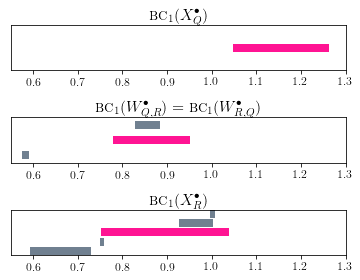

In [121]:
### plot four barcodes (VR and Witness)

# plot barcodes
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (5, 4))
xleft = 0.55
xright = 1.3
labelsize = 12

### plot barcode_P ###
index = np.argsort(barcode_Q[:,0]).tolist()
plot_barcode(barcode_Q[index,:], ax = ax0, xleft = xleft, xright = xright, labelsize = labelsize, lw = 8, title = r'$\textsc{bc}_1(X^\bullet_Q)$')
# highlight selected bar
bar_idx = [index.index(i-1) for i in bar_Q]
color_barcode(ax0, barcode_Q[index,:], bar_idx = bar_idx, color = "#ff1493", lw = 8)

### plot witness barcode ###
index = np.argsort(barcode_W_QR[:,0]).tolist()
plot_barcode(barcode_W_QR[index,:], ax = ax1, xleft = xleft, xright = xright, labelsize = labelsize, lw = 8, title = r'$\textsc{bc}_1(W^\bullet_{Q, R}) = \textsc{bc}_1(W^\bullet_{R, Q})$')
# highlight selected bar
bar_idx = [index.index(i-1) for i in bar_W_QR]
color_barcode(ax1, barcode_W_QR[index,:], bar_idx = bar_idx, color = "#ff1493", lw = 8)


### plot barcode_Q ###
index = np.argsort(barcode_R[:,0]).tolist()
plot_barcode(barcode_R[index,:], ax = ax2, xleft = xleft, xright = xright, labelsize = labelsize, lw = 8, title = r'$\textsc{bc}_1(X^\bullet_R)$')
# highlight selected bar
bar_idx = [index.index(i-1) for i in bar_R]
color_barcode(ax2, barcode_R[index,:], bar_idx = bar_idx, color = "#ff1493", lw = 8)

fig.tight_layout() 
#plt.savefig("figures/annulus_QR_witness_barcodes.pdf")
plt.show()

In [ ]:
# plot the relevant cycle reps

In [122]:
# load data
with h5py.File("data/annulus_same_distribution/classrep.jld", "r") as f:
    class_Q = f["class_P"][()]
    class_union = f["class_union"][()]
    class_R = f["class_Q"][()]

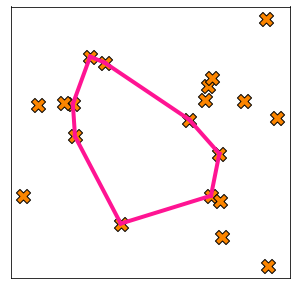

In [126]:
# plot class_Q
fig, ax = plt.subplots(figsize = (5,5))
size = 200

# plot points Q
plot_points(Q, Q, P_size = size, Q_alpha = 0, ax = ax, legend = False, P_color = color2, P_marker = "X" ) # set Q_alpha = 0 to only show Q
# plot class_Q
plot_cycle(class_Q, ax, Q)

#plt.savefig("figures/annulus_classrep_Q.pdf")
plt.show()

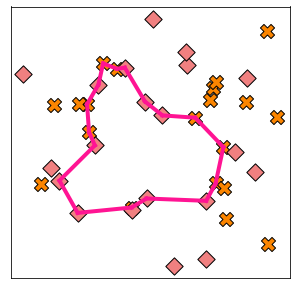

In [131]:
fig, ax = plt.subplots(figsize = (5,5))
size = 200
plot_points(Q, R, P_size = size, P_label = "Q", P_color = color2,P_marker = "X",
            Q_size = 150, Q_label = "R", Q_color = "lightcoral", Q_marker = "D", ax = ax, legend = False)

# plot class in union
plot_cycle(class_union, ax, np.concatenate((Q,R)))
#plt.savefig("figures/annulus_classrep_union.pdf")
plt.show()

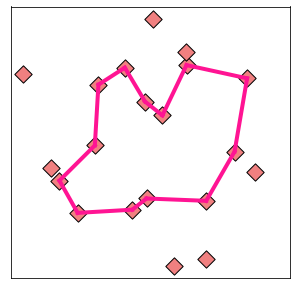

In [134]:
# plot class_R
fig, ax = plt.subplots(figsize = (5,5))
size = 200
plot_points(Q, R, P_size = size, P_label = "Q", P_color = color2,P_marker = "X", P_alpha = 0,
            Q_size = 150, Q_label = "R", Q_color = "lightcoral", Q_marker = "D", ax = ax, legend = False)

# plot class in union
plot_cycle(class_R, ax, R)
#plt.savefig("figures/annulus_classrep_R.pdf")
plt.show()

# 4. Semi-circles
From `examples/data/trivial_match`

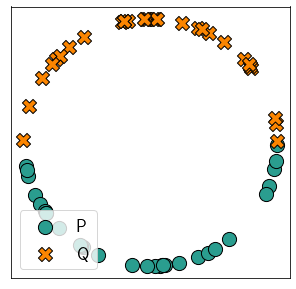

In [67]:
# load points
with h5py.File("data/semicircles/points.jld", "r") as f:
    P = np.array(f["P"][()])
    Q = np.array(f["Q"][()])

# plot
size = 200
# plot points P, Q
plt.figure(figsize = (5,5))
plot_points(P, Q, P_size = size, Q_size = size)

#plt.savefig("figures/semi_circle.pdf")
plt.show()

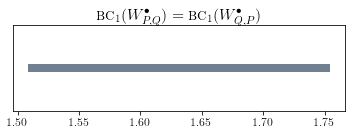

In [68]:
### plot Witness barcode

# load
with h5py.File("data/semicircles/W_barcode.jld", "r") as f:
    barcode = np.array(f["W"][()]).transpose()

# plot
fig, (ax0) = plt.subplots(figsize = (5, 2))
labelsize = 12

plot_barcode(barcode, ax = ax0,  lw = 8, labelsize = labelsize, title = r'$\textsc{bc}_1(W^\bullet_{P, Q}) = \textsc{bc}_1(W^\bullet_{Q, P})$')

fig.tight_layout() 
#plt.savefig("figures/semi_circle_W_barcode.pdf")
plt.show()

# 5. Illustrations of key steps in Algorithm 1
* From `examples/data/torus_circle`

Specify colors for `birth_bar`, `short_bar`, and `omega`


In [69]:
birth_color = "#13F0F0" # cyan
short_color = "#E63DFF" # purple
omega_color = "#FFC63D" # yellow-gold

## 5(a) Plot cycle $\tau$
<font color="red">NOTE:</font> need to add arrows for the square torus

In [70]:
# load data
with h5py.File("data/torus_circle/coords.h5", "r") as f:
    P = f["torus"][()].transpose()
    Q = f["circle"][()].transpose()

# load cycle
with h5py.File("data/torus_circle/cycle_tau.jld", "r") as f:
    tau = f["cycle"][()].tolist()

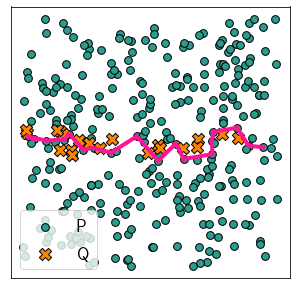

In [71]:
fig, ax = plt.subplots(figsize = (5,5))
# plot P and Q
plot_points(P, Q, ax, P_size = 60, Q_size = 150)

# plot cycle
plot_cycle_on_square_torus(tau, ax, P)

#plt.savefig("figures/torus_circle_tau.pdf")
plt.show()

## 5(b) Auxiliary barcode

In [72]:
# load data on auxiliary barcode
with h5py.File("data/torus_circle/aux_barcode.jld", "r") as f:
    aux_barcode = np.array(f["aux_barcode"][()]).transpose()
    ep0 = f["ep0"][()]
    birth_bar = f["birth_bar"][()]
    short_bars = f["short_bars"][()]
    omega = f["omega"][()]


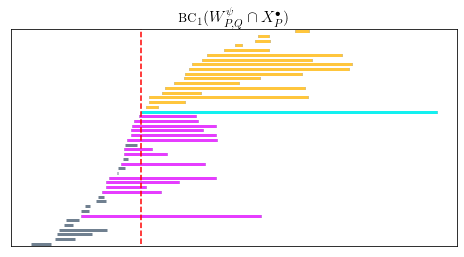

In [73]:
# sort barcode
index = np.argsort(aux_barcode[:,0]).tolist()

# find (new) index of birth bars, short bars, and omega
birth_idx = index.index(birth_bar - 1)
short_idx = [index.index(i-1) for i in short_bars]
omega_idx = [index.index(i-1) for i in omega]

fig, ax = plt.subplots(figsize = (8,4))

# plot the barcode
plot_barcode(aux_barcode[index,:], ax = ax, lw = 3, title = r'$\textsc{bc}_1(W^{\psi}_{P,Q} \cap X^\bullet_P)$')

# color the birth bar
color_barcode(ax, aux_barcode[index,:], bar_idx = [birth_idx], color = birth_color,lw = 3)

# color the short bars
color_barcode(ax, aux_barcode[index,:], bar_idx = short_idx, color = short_color, lw = 3)

# color the omega bars
color_barcode(ax, aux_barcode[index,:], bar_idx = omega_idx, color = omega_color, lw = 3)

# draw vertical line
ax.vlines(ep0, 0, len(index), color = "red", linestyle = "dashed")

# get rid of parameters
ax.set_xticks([])

#plt.savefig("figures/torus_circle_aux_barcode.pdf")
plt.show()

## 5(c) Plot cycle reps
<font color="red">NOTE:</font> need to add arrows for the square torus

In [74]:
# load cycle reps
with h5py.File("data/torus_circle/aux_cyclereps.jld", "r") as f:
    birth_rep = (f["birth_rep"][()]).tolist()
    short_rep = (f["short_rep"][()]).tolist()

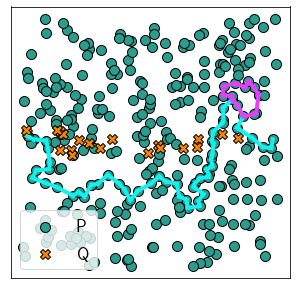

In [75]:
# plot
fig, ax = plt.subplots(figsize = (5,5))

# plot points P, Q
plot_points(P, Q, ax)

# plot birth cycle rep
plot_cycle_on_square_torus(birth_rep, ax, P, cycle_color = birth_color)

# plot short cycle rep
plot_cycle_on_square_torus(short_rep, ax, P, cycle_color = short_color)

#plt.savefig("figures/torus_circle_aux_cycle_reps.pdf")
plt.show()

# 6. bar-to-bars persistent extension method
* From `examples/torus_circle`

## (a) plot Witness and VR barcodes

In [76]:
# load data on auxiliary barcode
with h5py.File("data/torus_circle/W_VR_barcodes.jld", "r") as f:
    W_barcode = np.array(f["W_barcode"][()]).transpose()
    VR_barcode = np.array(f["VR_barcode"][()]).transpose()

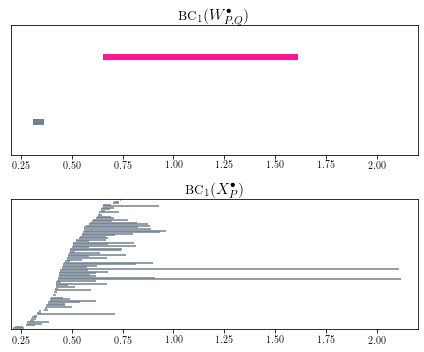

In [85]:
fig, ax = plt.subplots(nrows = 2, figsize = (6, 5))

xleft = 0.2
xright = 2.2

### plot W_barcode
plot_barcode(W_barcode, ax = ax[0], lw = 6, xleft = xleft, xright = xright, title = r'$\textsc{bc}_1(W^{\bullet}_{P,Q})$')

# color the long bar
color_barcode(ax[0], W_barcode, bar_idx = [1], color = "#ff1493",lw = 6)

### plot VR_barcode
# sort barcode
index = np.argsort(VR_barcode[:,0]).tolist()
# plot
plot_barcode(VR_barcode[index,:], ax = ax[1], lw = 1.5, xleft = xleft, xright = xright, title = r'$\textsc{bc}_1(X^{\bullet}_{P})$')

fig.tight_layout()
#plt.savefig("figures/torus_circle_W_VR_barcodes.pdf")
plt.show()

## (b) cycle representative of terminal class
* This is the same figure as 5(a)

In [83]:
# load data
with h5py.File("data/torus_circle/coords.h5", "r") as f:
    P = f["torus"][()].transpose()
    Q = f["circle"][()].transpose()

# load cycle
with h5py.File("data/torus_circle/cycle_tau.jld", "r") as f:
    tau = f["cycle"][()].tolist()

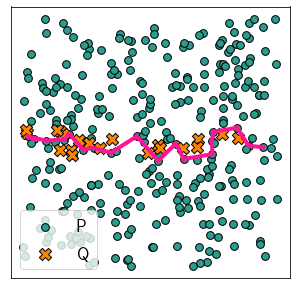

In [84]:
fig, ax = plt.subplots(figsize = (5,5))
# plot P and Q
plot_points(P, Q, ax, P_size = 60, Q_size = 150)

# plot cycle
plot_cycle_on_square_torus(tau, ax, P)

#plt.savefig("figures/torus_circle_tau.pdf")
plt.show()

## (c) example cycle extension

In [86]:
# load cycle reps
with h5py.File("data/torus_circle/aux_cyclereps.jld", "r") as f:
    birth_rep = (f["birth_rep"][()]).tolist()
    short_rep = (f["short_rep"][()]).tolist()

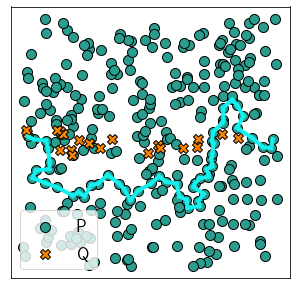

In [87]:
# plot
fig, ax = plt.subplots(figsize = (5,5))

# plot points P, Q
plot_points(P, Q, ax)

# plot birth cycle rep
plot_cycle_on_square_torus(birth_rep, ax, P, cycle_color = birth_color)

#plt.savefig("figures/torus_circle_aux_birth_cyclerep.pdf")
plt.show()

## (d) example D-bar representative

In [88]:
# load data
with h5py.File("data/torus_circle/D_bar_rep_alt.jld", "r") as f:
    D_bar_rep = (f["D_bar_rep"][()]).tolist()
    D_bar_rep_alt = (f["D_bar_rep_alt"][()]).tolist()

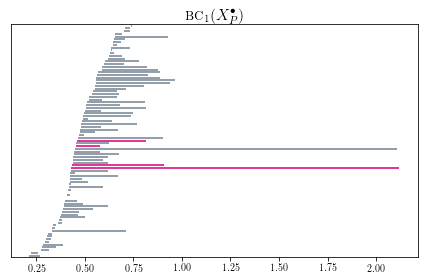

In [91]:
# plot barcode
fig, ax = plt.subplots(figsize = (6, 4))

# sort bars & plot
index = np.argsort(VR_barcode[:,0]).tolist()
plot_barcode(VR_barcode[index,:], ax = ax, lw = 1.5, title = r'$\textsc{bc}_1(X^{\bullet}_{P})$')

# find index of D-bar rep & highlight
D_bar_rep_idx = [index.index(i-1) for i in D_bar_rep]
color_barcode(ax, VR_barcode[index,:], bar_idx = D_bar_rep_idx, color = "#ff1493",lw = 1.5)

fig.tight_layout()
#plt.savefig("figures/torus_circle_Dbar_rep.pdf")
plt.show()

## (e) alternative bar rep

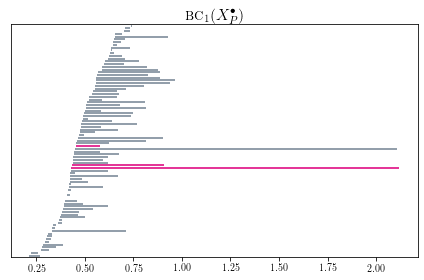

In [93]:
# plot barcode
fig, ax = plt.subplots(figsize = (6, 4))

# sort bars & plot
index = np.argsort(VR_barcode[:,0]).tolist()
plot_barcode(VR_barcode[index,:], ax = ax, lw = 1.5, title = r'$\textsc{bc}_1(X^{\bullet}_{P})$')

# find index of D-bar rep & highlight
D_bar_altrep_idx = [index.index(i-1) for i in D_bar_rep_alt]

color_barcode(ax, VR_barcode[index,:], bar_idx = D_bar_altrep_idx, color = "#ff1493",lw = 1.5)

fig.tight_layout()
#plt.savefig("figures/torus_circle_Dbar_rep_alt.pdf")
plt.show()

# 7. Analogous bars method solution overview
* data from `data/torus_circle`
* The actual figure was hand-drawn using Inkscape. The figures in this section are imported to Inkscape. See `analogous_bars_summary.svg`

In [98]:
# load barcodes
with h5py.File("data/torus_circle/four_barcodes.jld", "r") as f:
    barcode_P = np.array(f["barcode_P"][()]).transpose()
    barcode_W_P = np.array(f["barcode_W_PQ"][()]).transpose()
    barcode_W_Q = np.array(f["barcode_W_QP"][()]).transpose()
    barcode_Q = np.array(f["barcode_Q"][()]).transpose()
    
with h5py.File("data/torus_circle/analogous_bars.jld", "r") as f:
    bar_P = f["bar_P"][()].tolist()
    bar_W_PQ = f["bar_W_PQ"][()].tolist()
    bar_W_QP = f["bar_W_QP"][()].tolist()
    bar_Q = f["bar_Q"][()].tolist()
 
# load cycle reps
with h5py.File("data/torus_circle/analogous_method_classreps.jld", "r") as f:
    cycle_P = f["class_P"][()].tolist()
    cycle_W_PQ = f["class_W_PQ"][()].tolist()
    cycle_W_QP = f["class_W_QP"][()].tolist()
    cycle_Q = f["class_Q"][()].tolist()

# points
with h5py.File("data/torus_circle/coords.h5", "r") as f:
    P = f["circle"][()].transpose()
    Q = f["torus"][()].transpose()

Plot summary (barcodes & cycle reps)

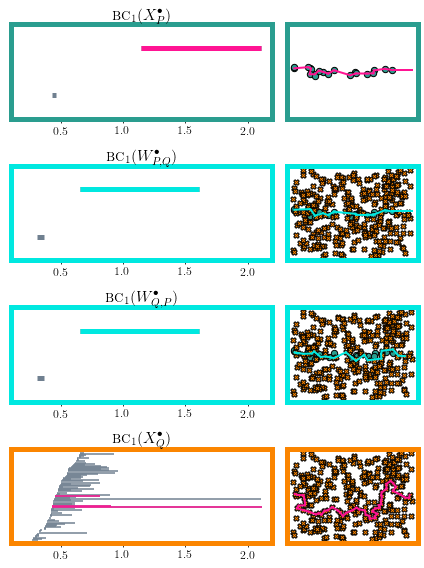

In [100]:
# plot barcodes 
fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (6, 8),
                    gridspec_kw = {"width_ratios": [2,1]})
xleft = 0.1
xright = 2.2
labelsize = 12
P_color = color1 # dark green
Q_color = color2 # dark orange
W_color = "#00E8E0" # cyan
VR_color = "#ff1493" # pink
#labelsize = 12

##### PLOT BARCODES #####
### barcode(VR(P)) ###
# sort and plot barcode
index = np.argsort(barcode_P[:,0]).tolist()
plot_barcode(barcode_P[index,:], ax = ax[0][0], lw = 5, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(X^\bullet_P)$')
# highlight the bar extension 
bar_idx = [index.index(i-1) for i in bar_P]
color_barcode(ax[0][0], barcode_P[index,:], bar_idx = bar_idx, color = VR_color, lw = 5)
# color the boundary box & thicken
for pos in ['top', 'bottom', 'right', 'left']:
    ax[0][0].spines[pos].set_edgecolor(P_color)
    ax[0][0].spines[pos].set_linewidth(5)

### barcode(W_PQ)###
# sort and plot barcode
index = np.argsort(barcode_W_P[:,0]).tolist()
plot_barcode(barcode_W_P[index,:], ax = ax[1][0], lw = 5, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(W^\bullet_{P, Q})$')
# highlight selected bar in Witness barcode
bar_idx = [index.index(i-1) for i in bar_W_PQ]
color_barcode(ax[1][0], barcode_W_P[index,:], bar_idx = bar_idx, color = W_color, lw = 5)
# color the boundary box & thicken
for pos in ['top', 'bottom', 'right', 'left']:
    ax[1][0].spines[pos].set_edgecolor(W_color)
    ax[1][0].spines[pos].set_linewidth(5)

### barcode(W_QP)###
# sort and plot barcode
index = np.argsort(barcode_W_Q[:,0]).tolist()
plot_barcode(barcode_W_Q[index,:], ax = ax[2][0], lw = 5, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(W^\bullet_{Q, P})$')
# highlight selected bar in Witness barcode
bar_idx = [index.index(i-1) for i in bar_W_QP]
color_barcode(ax[2][0], barcode_W_Q[index,:], bar_idx = bar_idx, color = W_color, lw = 5)
# color the boundary box & thicken
for pos in ['top', 'bottom', 'right', 'left']:
    ax[2][0].spines[pos].set_edgecolor(W_color)
    ax[2][0].spines[pos].set_linewidth(5)

### barcode(VR(Q)) ###
# sort and plot barcode
index = np.argsort(barcode_Q[:,0]).tolist()
plot_barcode(barcode_Q[index,:], ax = ax[3][0], lw = 1.5, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(X^\bullet_Q)$')
# highlight bar extension to barcode(VR(Q))
bar_idx = [index.index(i-1) for i in bar_Q]
color_barcode(ax[3][0], barcode_Q[index,:], bar_idx = bar_idx, color = VR_color, lw = 1.5)
# color the boundary box & thicken
for pos in ['top', 'bottom', 'right', 'left']:
    ax[3][0].spines[pos].set_edgecolor(Q_color)
    ax[3][0].spines[pos].set_linewidth(5)


##### PLOT CYCLE REPS #####
### plot cycle_P ###
# plot points & cycle rep
plot_points(P, Q, ax[0][1], legend = False, P_size = 40, Q_size = 0)
plot_cycle_on_square_torus(cycle_P, ax[0][1], P, linewidth = 2, cycle_color = VR_color)
# plot additional cycle reps (to the end of the frame)
i = np.argmax(P[:,0])
x1 = P[i, 0]
x2 = math.pi * 2 
y1 = y2 = P[i,1]
ax[0][1].plot([x1, x2], [y1, y2], c = VR_color, lw = 2)
# color the boundary box & thicken
for pos in ['top', 'bottom', 'right', 'left']:
    ax[0][1].spines[pos].set_edgecolor(P_color)
    ax[0][1].spines[pos].set_linewidth(5)

### plot cycle_W_PQ ###
# plot points & cycle rep
plot_points(P, Q, ax[1][1], legend = False, P_size = 40, Q_size = 30)
plot_cycle_on_square_torus(cycle_W_PQ, ax[1][1], P, linewidth = 2, cycle_color = W_color)
# plot additional cycle reps (to the end of the frame)
i = np.argmax(P[:,0])
x1 = P[i, 0]
x2 = math.pi * 2 
y1 = y2 = P[i,1]
ax[1][1].plot([x1, x2], [y1, y2], c = W_color, lw = 2)
# color the boundary box & thicken
for pos in ['top', 'bottom', 'right', 'left']:
    ax[1][1].spines[pos].set_edgecolor(W_color)
    ax[1][1].spines[pos].set_linewidth(5)


### plot cycle_W_QP ###
# plot points & cycle rep
plot_points(P, Q, ax[2][1], legend = False, P_size = 40, Q_size = 30)
plot_cycle_on_square_torus(cycle_W_QP, ax[2][1], Q, linewidth = 2, cycle_color = W_color)
# color the boundary box & thicken
for pos in ['top', 'bottom', 'right', 'left']:
    ax[2][1].spines[pos].set_edgecolor(W_color)
    ax[2][1].spines[pos].set_linewidth(5)

### plot cycle_Q ###
# plot points & cyclerep
plot_points(P, Q, ax[3][1], legend = False, P_size = 0, Q_size = 30)
plot_cycle_on_square_torus(cycle_Q, ax[3][1], Q, linewidth = 2, cycle_color = VR_color)
# color the boundary box & thicken
for pos in ['top', 'bottom', 'right', 'left']:
    ax[3][1].spines[pos].set_edgecolor(Q_color)
    ax[3][1].spines[pos].set_linewidth(5)

fig.tight_layout() 
#plt.savefig("figures/analogous_bars_overview.svg")
plt.show()

In [101]:
# load distance matrices
file = open("data/torus_circle/distance_circle.csv")
D_circle = np.loadtxt(file)

file = open("data/torus_circle/distance_torus.csv")
D_torus = np.loadtxt(file)

file = open("data/torus_circle/distance_circle_torus.csv")
D_circle_torus = np.loadtxt(file)

file = open("data/torus_circle/distance_torus_circle.csv")
D_torus_circle = np.loadtxt(file)

D = np.zeros((320, 320))
D[:20, :20] = D_circle
D[20:, 20:] = D_torus
D[:20, 20:] = D_circle_torus
D[20:, :20] = D_torus_circle

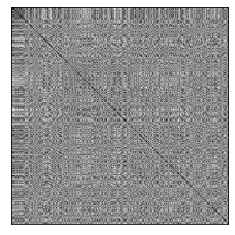

In [102]:
plt.imshow(D, cmap = "gray")
plt.xticks([])
plt.yticks([])
#plt.savefig("figures/analogous_bars_distance.svg")
plt.show()

# 8. Torus & confused circle

## (a) plot points P, Q

In [52]:
# load data
with h5py.File("data/torus_confused_circle/data.jld", "r") as f:
    Q = f["torus"][()].transpose() # 3D coordinates
    Q_theta = f["torus_theta"][()]
    Q_phi = f["torus_phi"][()]
    P = f["circle"][()].transpose() # 3D coordinates
    P_theta = f["circle_theta"][()] 
    P_phi = f["circle_phi"][()]
  
# get coordinates on square torus
P_2D =np.array([P_theta, P_phi]).transpose()
Q_2D = np.array([Q_theta, Q_phi]).transpose()

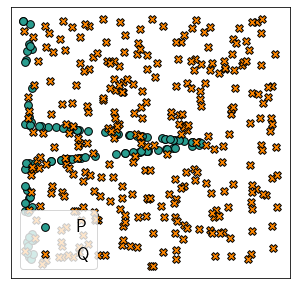

In [53]:
fig, ax = plt.subplots(figsize = (5,5))
# plot P and Q
plot_points(P_2D, Q_2D, ax, P_size = 60, Q_size = 60)

#plt.savefig("figures/torus_confused_circle.pdf")
plt.show()

## (b) Plot feature-centric analogous bars method

In [54]:
# load barcodes
with h5py.File("data/torus_confused_circle/feature_centric_analogous_bars.jld", "r") as f:
    barcode_P = np.array(f["barcode_VR_P"][()]).transpose()
    barcode_W_P = np.array(f["barcode_W_P"][()]).transpose()
    barcode_Q = np.array(f["barcode_VR_Q"][()]).transpose()
    bar_VR_P = f["bar_VR_P"][()].tolist()
    bar_VR_Q = f["bar_VR_Q"][()].tolist()
    VR_P_cycle = f["VR_P_cyclerep"][()].tolist()
    W_PQ_cycle = f["W_PQ_cyclerep"][()].tolist()
    W_QP_cycle = f["W_QP_cyclerep"][()].tolist()
    VR_Q_cycle = f["VR_Q_cyclerep"][()].tolist()

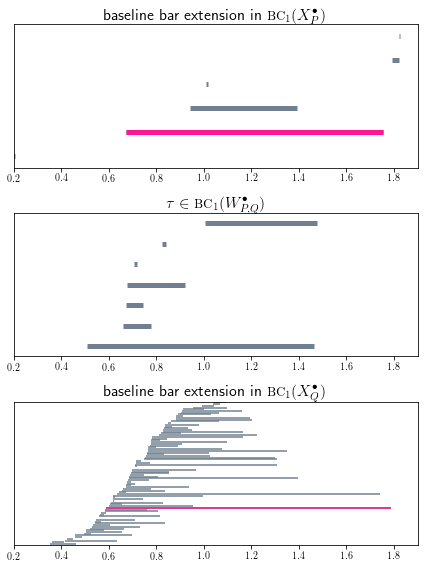

In [55]:
# plot barcodes 
fig, ax = plt.subplots(nrows = 3, figsize = (6, 8))
xleft = 0.2
xright = 1.9
W_color = "#00E8E0"
VR_color = "#ff1493"
#labelsize = 12

##### PLOT BARCODES #####
### VR_P_barcode ###
# sort and plot barcode
index = np.argsort(barcode_P[:,0]).tolist()
plot_barcode(barcode_P[index,:], ax = ax[0], lw = 5, xleft = xleft, xright = xright, title = r'baseline bar extension in $\textsc{bc}_1(X^\bullet_P)$')
# highlight the bar extension to barcode_P
bar_idx = [index.index(i-1) for i in bar_VR_P]
color_barcode(ax[0], barcode_P[index,:], bar_idx = bar_idx, color = VR_color, lw = 5)

### Witness barcode W_PQ###
# sort and plot barcode
index = np.argsort(barcode_W_P[:,0]).tolist()
plot_barcode(barcode_W_P[index,:], ax = ax[1], lw = 5, xleft = xleft, xright = xright, title = r'$\tau \in \textsc{bc}_1(W^\bullet_{P, Q})$')

### VR_Q_barcode ###
# sort and plot barcode
index = np.argsort(barcode_Q[:,0]).tolist()
plot_barcode(barcode_Q[index,:], ax = ax[2], lw = 1.5, xleft = xleft, xright = xright, title = r'baseline bar extension in $\textsc{bc}_1(X^\bullet_Q)$')
# highlight bar extension to barcode_Q
bar_idx = [index.index(i-1) for i in bar_VR_Q]
color_barcode(ax[2], barcode_Q[index,:], bar_idx = bar_idx, color = VR_color, lw = 1.5)


fig.tight_layout() 
#plt.savefig("figures/torus_confused_circle_feature_centric_barcodes.pdf")
plt.show()

Plot cyclereps

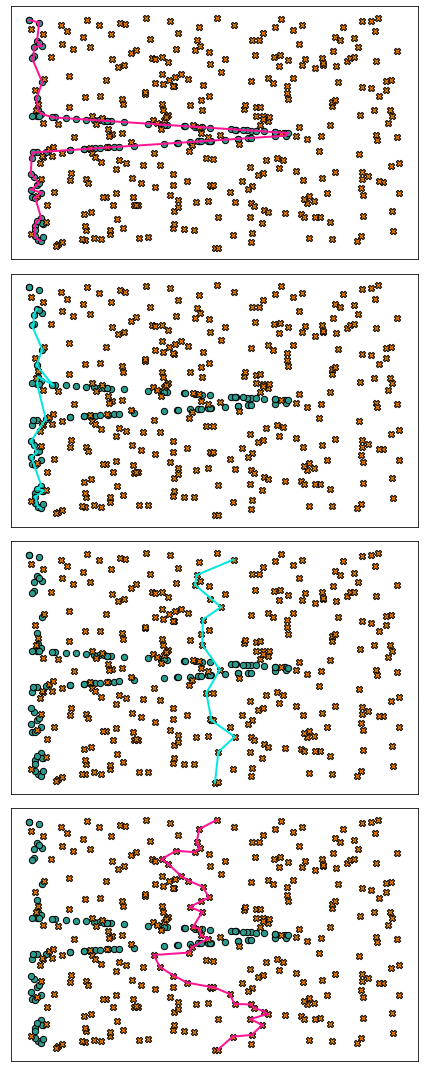

In [56]:
fig, ax = plt.subplots(nrows = 4, figsize = (6, 15))
xleft = 0.2
xright = 1.9
W_color = "#00E8E0"
VR_color = "#ff1493"
#labelsize = 12

##### PLOT CYCLE REPS #####
### plot cycle_P ###
plot_points(P_2D, Q_2D, ax[0], legend = False, P_size = 40, Q_size = 40)
plot_cycle_on_square_torus(VR_P_cycle, ax[0], P_2D, linewidth = 2, cycle_color = VR_color)

### plot cycle_W_PQ ###
plot_points(P_2D, Q_2D, ax[1], legend = False, P_size = 40, Q_size = 40)
plot_cycle_on_square_torus(W_PQ_cycle, ax[1], P_2D, linewidth = 2, cycle_color = W_color)

### plot cycle_W_QP ###
plot_points(P_2D, Q_2D, ax[2], legend = False, P_size = 40, Q_size = 40)
plot_cycle_on_square_torus(W_QP_cycle, ax[2], Q_2D, linewidth = 2, cycle_color = W_color)

### plot cycle_Q ###
plot_points(P_2D, Q_2D, ax[3], legend = False, P_size = 40, Q_size = 40)
plot_cycle_on_square_torus(VR_Q_cycle, ax[3], Q_2D, linewidth = 2, cycle_color = VR_color)

fig.tight_layout() 
#plt.savefig("figures/torus_confused_circle_feature_centric_cycles.pdf")
plt.show()

## (e) Summary of similarity-centric analogous bars method (Figure 11)

In [57]:
# load barcodes
with h5py.File("data/torus_confused_circle/similarity_centric_analogous_bars.jld", "r") as f:
    barcode_P = np.array(f["barcode_VR_P"][()]).transpose()
    barcode_W_P = np.array(f["barcode_W_P"][()]).transpose()
    barcode_Q = np.array(f["barcode_VR_Q"][()]).transpose()
    bar_VR_P = f["bar_VR_P"][()].tolist()
    bar_W_PQ = f["bar_W_PQ"][()].tolist()
    bar_W_QP = f["bar_W_QP"][()].tolist()
    bar_VR_Q = f["bar_VR_Q"][()].tolist()
    VR_P_cycle = f["VR_P_cyclerep"][()].tolist()
    W_PQ_cycle = f["W_PQ_cyclerep"][()].tolist()
    W_QP_cycle = f["W_QP_cyclerep"][()].tolist()
    VR_Q_cycle = f["VR_Q_cyclerep"][()].tolist()

Plot summary (barcodes & cycle reps)

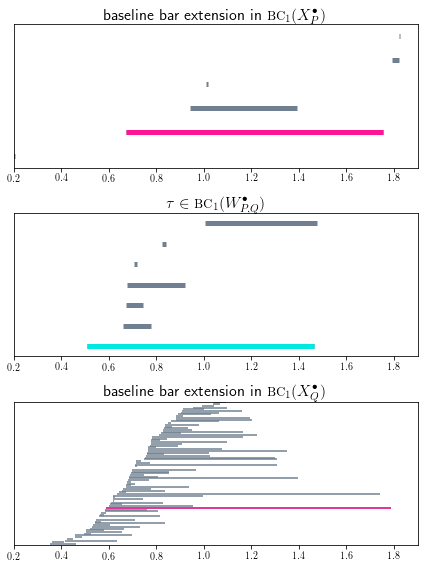

In [58]:
# plot barcodes 
fig, ax = plt.subplots(nrows = 3, figsize = (6, 8))
xleft = 0.2
xright = 1.9
W_color = "#00E8E0"
VR_color = "#ff1493"
#labelsize = 12

##### PLOT BARCODES #####
### VR_P_barcode ###
# sort and plot barcode
index = np.argsort(barcode_P[:,0]).tolist()
plot_barcode(barcode_P[index,:], ax = ax[0], lw = 5, xleft = xleft, xright = xright, title = r'baseline bar extension in $\textsc{bc}_1(X^\bullet_P)$')
# highlight the bar extension to barcode_P
bar_idx = [index.index(i-1) for i in bar_VR_P]
color_barcode(ax[0], barcode_P[index,:], bar_idx = bar_idx, color = VR_color, lw = 5)

### Witness barcode W_PQ###
# sort and plot barcode
index = np.argsort(barcode_W_P[:,0]).tolist()
plot_barcode(barcode_W_P[index,:], ax = ax[1], lw = 5, xleft = xleft, xright = xright, title = r'$\tau \in \textsc{bc}_1(W^\bullet_{P, Q})$')
# highlight selected bar in Witness barcode
bar_idx = [index.index(i-1) for i in bar_W_PQ]
color_barcode(ax[1], barcode_W_P[index,:], bar_idx = bar_idx, color = W_color, lw = 5)

### VR_Q_barcode ###
# sort and plot barcode
index = np.argsort(barcode_Q[:,0]).tolist()
plot_barcode(barcode_Q[index,:], ax = ax[2], lw = 1.5, xleft = xleft, xright = xright, title = r'baseline bar extension in $\textsc{bc}_1(X^\bullet_Q)$')
# highlight bar extension to barcode_Q
bar_idx = [index.index(i-1) for i in bar_VR_Q]
color_barcode(ax[2], barcode_Q[index,:], bar_idx = bar_idx, color = VR_color, lw = 1.5)


fig.tight_layout() 
#plt.savefig("figures/torus_confused_circle_similarity_barcodes.pdf")
plt.show()

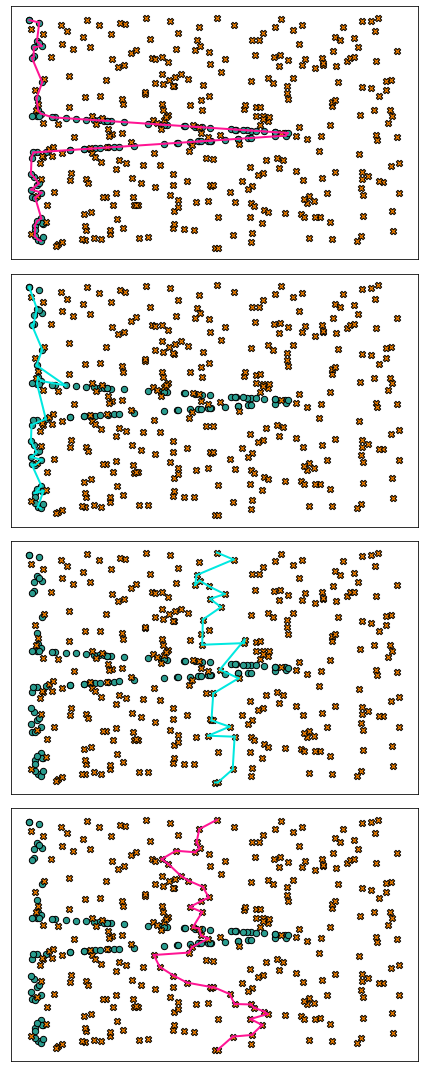

In [59]:
# plot barcodes 
fig, ax = plt.subplots(nrows = 4, figsize = (6, 15))
xleft = 0.2
xright = 1.9
W_color = "#00E8E0"
VR_color = "#ff1493"
#labelsize = 12

##### PLOT CYCLE REPS #####
### plot cycle_P ###
plot_points(P_2D, Q_2D, ax[0], legend = False, P_size = 40, Q_size = 40)
plot_cycle_on_square_torus(VR_P_cycle, ax[0], P_2D, linewidth = 2, cycle_color = VR_color)

### plot cycle_W_PQ ###
plot_points(P_2D, Q_2D, ax[1], legend = False, P_size = 40, Q_size = 40)
plot_cycle_on_square_torus(W_PQ_cycle, ax[1], P_2D, linewidth = 2, cycle_color = W_color)

### plot cycle_W_QP ###
plot_points(P_2D, Q_2D, ax[2], legend = False, P_size = 40, Q_size = 40)
plot_cycle_on_square_torus(W_QP_cycle, ax[2], Q_2D, linewidth = 2, cycle_color = W_color)

### plot cycle_Q ###
plot_points(P_2D, Q_2D, ax[3], legend = False, P_size = 40, Q_size = 40)
plot_cycle_on_square_torus(VR_Q_cycle, ax[3], Q_2D, linewidth = 2, cycle_color = VR_color)

fig.tight_layout() 
#plt.savefig("figures/torus_confused_circle_similarity_cycles.pdf")
plt.show()

# Double-torus example (Figures 13 - 15)

## (a) plot points

In [121]:
# load points
with h5py.File("data/double_torus/data.jld2", "r") as f:
    P = f["circle"][()].transpose()
    Q = f["double_torus"][()].transpose()

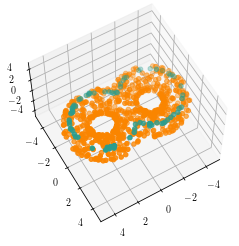

In [122]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(P[:,0], P[:,1], P[:,2], c = color1)
ax.scatter(Q[:,0], Q[:,1], Q[:,2], c =color2)
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.view_init(60, 60)
#plt.savefig("figures/double_torus_points.pdf")
plt.show()

## (b) plot two cycles on the double torus

No handles with labels found to put in legend.


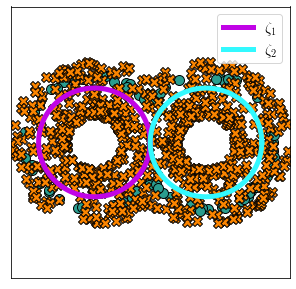

In [123]:
# plot in 2dim
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot()

# plot points
plot_points(P, Q, ax, P_label = "", Q_label = "")

# plot the two cycles
R = 2
r = 1

### cycle Zeta 1
# torus centered at (-2, 0, 0)
center1_x = -2
center1_y = 0
center1_z = 0

# cycle
theta1 = [math.pi/2] * 400
phi1= np.arange(0,2 * math.pi, math.pi / 200)
x1 = (R + r * np.cos(theta1) ) * np.cos(phi1) + center1_x
y1 = (R + r * np.cos(theta1)) * np.sin(phi1) + center1_y
z1 = r * np.sin(theta1) + center1_z

ax.plot(x1, y1, lw =5, label=r'$\zeta_1$', c = "#C104E6", alpha = 1)

### cycle zeta 2
# torus centered at (2, 0, 0)
center2_x = 2
center2_y = 0
center2_z = 0

# cycle
theta2 = [math.pi/2] * 400
phi2= np.arange(0,2 * math.pi, math.pi / 200)
x2 = (R + r * np.cos(theta2) ) * np.cos(phi2) + center2_x
y2 = (R + r * np.cos(theta2)) * np.sin(phi2) + center2_y
z2 = r * np.sin(theta2) + center2_z

ax.plot(x2, y2,lw =5, label=r'$\zeta_2$', c = "#33F9FF", alpha = 1)

ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.legend(fontsize = 15)

#plt.savefig("figures/double_torus_points_with_cycles.pdf")
plt.show()

## (c) barcodes

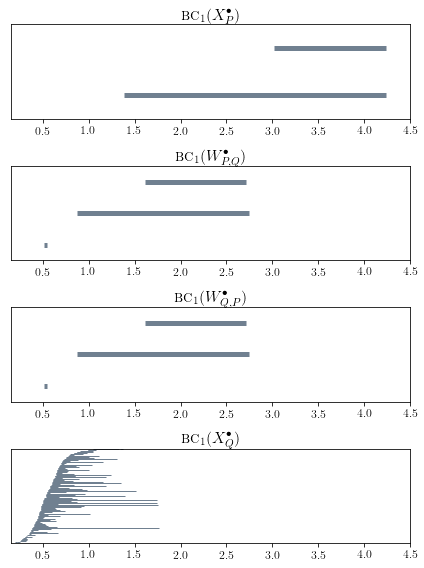

In [125]:
# load data
with h5py.File("data/double_torus/barcodes.jld", "r") as f:
    barcode_P = f["barcode_P"][()].transpose()
    barcode_W_PQ = f["barcode_W_PQ"][()].transpose()
    barcode_W_QP = f["barcode_W_QP"][()].transpose()
    barcode_Q = f["barcode_Q"][()].transpose()
    
# plot barcodes
fig, ax = plt.subplots(nrows = 4, figsize = (6, 8))
xleft = 0.15
xright = 4.5
labelsize = 12

# plot VR_P_barcode 
index = np.argsort(barcode_P[:,0]).tolist()
plot_barcode(barcode_P[index,:], ax = ax[0], lw = 5, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(X^\bullet_P)$')

# plot Winess barcode
index = np.argsort(barcode_W_PQ[:,0]).tolist()
plot_barcode(barcode_W_PQ[index,:], ax = ax[1], lw = 5, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(W^\bullet_{P, Q})$')

# plot Winess barcode
index = np.argsort(barcode_W_QP[:,0]).tolist()
plot_barcode(barcode_W_QP[index,:], ax = ax[2], lw = 5, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(W^\bullet_{Q, P})$')

# plot VR_Q_barcode
index = np.argsort(barcode_Q[:,0]).tolist()
plot_barcode(barcode_Q[index,:], ax = ax[3], lw = 1, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(X^\bullet_Q)$')


fig.tight_layout() 
#plt.savefig("figures/double_torus_barcodes.pdf")
plt.show()

## (d) cycle representatives of extensions

In [126]:
with h5py.File("data/double_torus/extension_example.jld", "r") as f:
    cycle_W_QP = f["cycle_W_QP"][()]
    bar_ext = f["bar_ext"][()]
    bar_ext_cyclerep = f["bar_ext_cyclerep"][()]

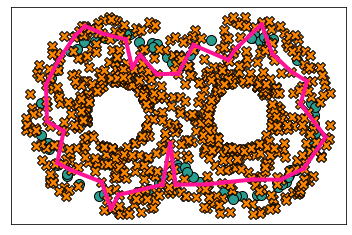

In [127]:
fig = plt.figure()
ax = fig.add_subplot()

# plot points
plot_points(P, Q, ax = ax, legend = False)

# plot cycle
plot_cycle(cycle_W_QP, ax, Q)
    
#plt.savefig("figures/double_torus_cycle_W_QP.pdf")
plt.show()

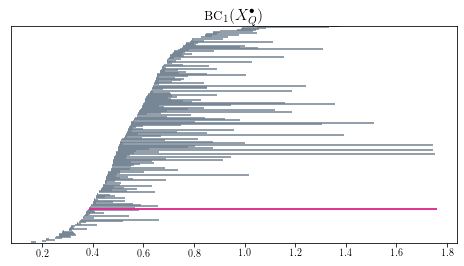

In [129]:
# plot barcodes
fig, ax = plt.subplots(figsize = (8, 4))

# sort and plot barcode
index = np.argsort(barcode_Q[:,0]).tolist()
plot_barcode(barcode_Q[index,:], ax = ax, lw = 1.5, title = r'$\textsc{bc}_1(X^\bullet_Q)$')

# find index of bar extension and color
bar_idx = [index.index(i-1) for i in bar_ext]
color_barcode(ax, barcode_Q[index,:], bar_idx = bar_idx, color = "#ff1493", lw = 1.5)

#plt.savefig("figures/double_torus_bar_ext.pdf")
plt.show()

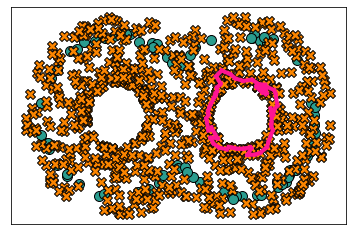

In [130]:
fig = plt.figure()
ax = fig.add_subplot()

# plot points
plot_points(P, Q, ax = ax, legend = False)

# plot cycle
plot_cycle(bar_ext_cyclerep, ax, Q)
    
#plt.savefig("figures/double_torus_bar_ext_cyclerep.pdf")
plt.show()

## (e) alternative cycle extension

In [131]:
with h5py.File("data/double_torus/alternative_extension.jld", "r") as f:
    params = f["parameters"][()].tolist()
    bar_ext = f["bar_ext"][()].tolist()
    epsilon = f["epsilon"][()]
    classrep = f["classrep"][()].tolist()

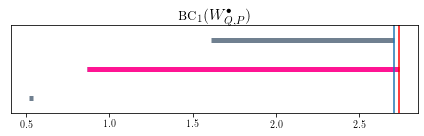

In [133]:
# plot barcodes
fig, ax = plt.subplots(figsize = (6, 2))

# plotbarcode_Q
index = np.argsort(barcode_W_QP[:,0]).tolist()
plot_barcode(barcode_W_QP[index,:], ax = ax, lw = 5, title = r'$\textsc{bc}_1(W^\bullet_{Q,P})$')

# find index of bar extension and color
classnum = 3
bar_idx = [index.index(classnum-1)]
color_barcode(ax, barcode_W_QP[index,:], bar_idx = bar_idx, color = "#ff1493", lw = 5)

# plot the two parameters in vertical lines
ax.vlines(params[1], -0.5, len(index), color = "red")
ax.vlines(params[0], -0.5, len(index))

fig.tight_layout() 
#plt.savefig("figures/double_torus_alternative_params.pdf")
plt.show()

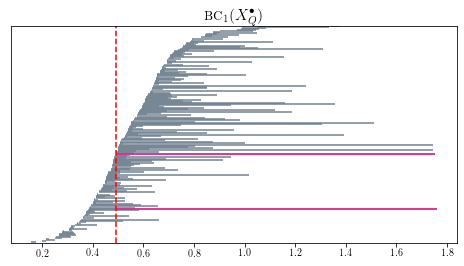

In [134]:
# plot barcodes
fig, ax = plt.subplots(figsize = (8, 4))

# plot barcode_Q
index = np.argsort(barcode_Q[:,0]).tolist()
plot_barcode(barcode_Q[index,:], ax = ax, lw = 1.5, title = r'$\textsc{bc}_1(X^\bullet_Q)$')

# highlight the bar extension
bar_idx = [index.index(i-1) for i in bar_ext]
color_barcode(ax, barcode_Q[index,:], bar_idx = bar_idx, color = "#ff1493", lw = 1.5, epsilon = epsilon)

# plot vertical line for parameter
ax.vlines(epsilon, -0.5, len(index), color = "red", linestyle = "dashed")

#plt.savefig("figures/double_torus_alt_bar_extension.pdf")
plt.show()

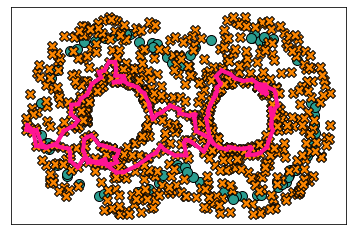

In [135]:
fig = plt.figure()
ax = fig.add_subplot()

# plot points
plot_points(P, Q, ax = ax, legend = False)

# plot cycle
plot_cycle(classrep, ax, Q)
    
#plt.savefig("figures/double_torus_alt_cycle_W_QP.pdf")
plt.show()

# Two samples from torus

In [136]:
# load points
f = h5py.File("data/torus_two_samples/data.jld", "r")
P = np.array(f["P"][()]).transpose()
P_theta = np.array(f["P_theta"][()])
P_phi = np.array(f["P_phi"][()])
Q = np.array(f["Q"][()]).transpose()
Q_theta = np.array(f["Q_theta"][()])
Q_phi = np.array(f["Q_phi"][()])
f.close()

# adjust theta values for better figures
P_theta_new = [i + 2 * math.pi if i < 0.2 else i for i in P_theta]
Q_theta_new = [i + 2 * math.pi if i < 0.2 else i for i in Q_theta]

P = np.concatenate([[P_theta_new], [P_phi]], axis = 0).transpose()
Q = np.concatenate([[Q_theta_new], [Q_phi]], axis = 0).transpose()

# load barcodes
with h5py.File("data/torus_two_samples/barcodes.jld", "r") as f:
    VR_P_barcode = (f["VR_P"][()]).transpose()
    W_P_Q_barcode = (f["W_P_Q"][()]).transpose()
    W_Q_P_barcode = (f["W_Q_P"][()]).transpose()
    VR_Q_barcode = (f["VR_Q"][()]).transpose()
    
# load example match bars & cycle reps
with h5py.File("data/torus_two_samples/example_match.jld", "r") as f:
    VR_P_bar = [f["VR_P_bar"][()]]
    VR_Q_bar = [f["VR_Q_bar"][()]]
    
    VR_P_rep = f["VR_P_classrep"][()]
    cycle_W_PQ = f["cycle_W_PQ"][()]
    cycle_W_QP = f["cycle_W_QP"][()]
    VR_Q_rep = f["VR_Q_classrep"][()]

Plot points  

<b> TO DO </b>: <span style="color:red">Add arrows for square torus</span>

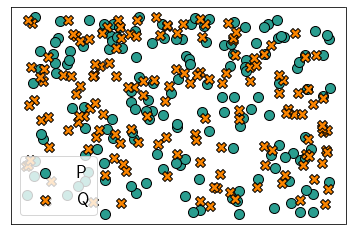

In [137]:
# plot points
size = 100

plot_points(P, Q, P_size = size, Q_size = size)

#plt.savefig("figures/torus_two_samples.pdf")
plt.show()

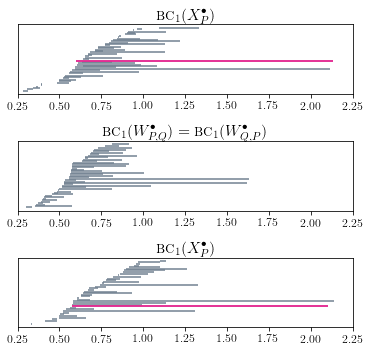

In [140]:
# plot barcodes 
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (5, 5))
xleft = 0.25
xright = 2.25
labelsize = labelsize

# plot barcode_P
index = np.argsort(VR_P_barcode[:,0]).tolist()
index[18], index[22] = index[22], index[18]
plot_barcode(VR_P_barcode[index,:], ax = ax0, lw =1.5, ybottom = -1, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(X^\bullet_P)$')
# highlight bar extension
bar_idx = [index.index(i-1) for i in VR_P_bar]
color_barcode(ax0, VR_P_barcode[index,:], bar_idx = bar_idx, color = VR_color, lw = 1.5)

# plot Witness barcode
index = np.argsort(W_P_Q_barcode[:,0]).tolist()
plot_barcode(W_P_Q_barcode[index,:], ax = ax1, lw =1.5, ybottom = -1, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(W^\bullet_{P,Q}) = \textsc{bc}_1(W^\bullet_{Q,P})$')

# plot barcode_Q
index = np.argsort(VR_Q_barcode[:,0]).tolist()
plot_barcode(VR_Q_barcode[index,:], ax = ax2, lw =1.5, ybottom = -1, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(X^\bullet_P)$')
# highlight bar extension
bar_idx = [index.index(i-1) for i in VR_Q_bar]
color_barcode(ax2, VR_Q_barcode[index,:], bar_idx = bar_idx, color = VR_color, lw = 1.5)

plt.tight_layout()

#plt.savefig("figures/torus_two_samples_four_barcodes.pdf")
plt.show()

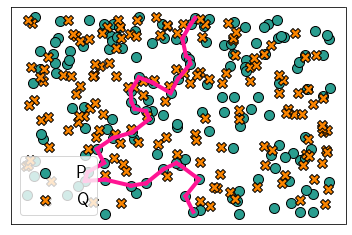

In [144]:
# plot cycle rep in VR_P
size = 100

fig, ax = plt.subplots()
plot_points(P, Q, ax = ax, P_size = size, Q_size = size)
plot_cycle_on_square_torus(VR_P_rep, ax, P)
#plt.savefig("figures/torus_two_samples_VR_P_classrep.pdf")
plt.show()

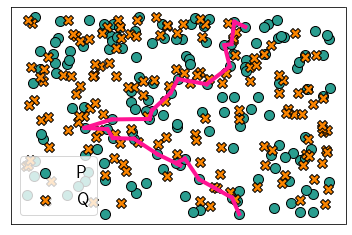

In [145]:
# plot cycle rep in W_PQ
size = 100

fig, ax = plt.subplots()
plot_points(P, Q, ax = ax, P_size = size, Q_size = size)
plot_cycle_on_square_torus(cycle_W_PQ, ax, P)
#plt.savefig("figures/torus_two_samples_W_PQ_classrep.pdf")
plt.show()

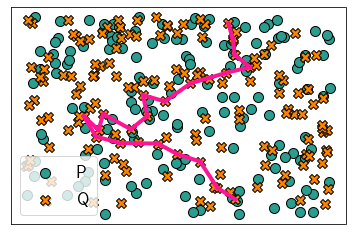

In [146]:
# plot cycle rep in W_QP
size = 100

fig, ax = plt.subplots()
plot_points(P, Q, ax = ax, P_size = size, Q_size = size)
plot_cycle_on_square_torus(cycle_W_QP, ax, Q)
#plt.savefig("figures/torus_two_samples_W_QP_classrep.pdf")
plt.show()

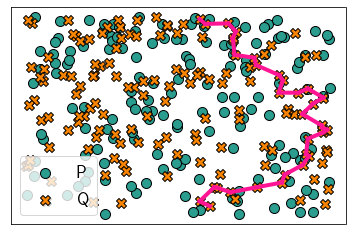

In [147]:
# plot cycle rep in VR_Q
size = 100

fig, ax = plt.subplots()
plot_points(P, Q, ax = ax, P_size = size, Q_size = size)
plot_cycle_on_square_torus(VR_Q_rep, ax, Q)
#plt.savefig("figures/torus_two_samples_VR_Q_classrep.pdf")
plt.show()

# clustering & centroid

## (a) plot points

In [148]:
with h5py.File("data/clustering/points.jld", "r") as f:
    points = f["points"][()]
    centroids = f["centroids"][()]
    D = f["D"][()]
    
with h5py.File("data/clustering/clusters.jld", "r") as f:
    clusters = f["clusters"][()].tolist()


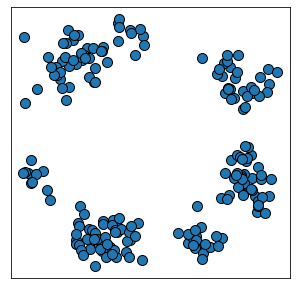

In [149]:
# plot points
plt.figure(figsize=(5,5))
plt.scatter(points[:,0], points[:,1], s = 100, edgecolors = "black")
plt.xticks([])
plt.yticks([])
#plt.savefig("figures/clustering_points.pdf")
plt.show()

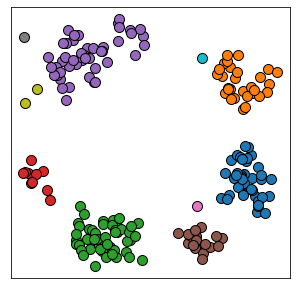

In [150]:
# clusters
n_clusters = len(np.unique(clusters))

# plot points
plt.figure(figsize=(5,5))
for j in range(1, n_clusters + 1):
    idx = [i for i, x in enumerate(clusters) if x == j]
    plt.scatter(points[idx, 0], points[idx, 1], s = 100, edgecolors = "black")

plt.xticks([])
plt.yticks([])
#plt.savefig("figures/clustering_clusters.pdf")
plt.show()


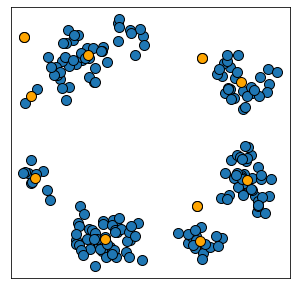

In [151]:
# plot points
plt.figure(figsize=(5,5))
plt.scatter(points[:,0], points[:,1], s = 100, edgecolors = "black")
plt.scatter(centroids[:,0], centroids[:,1], s = 100, edgecolors = "black", c = "orange")
plt.xticks([])
plt.yticks([])
#plt.savefig("figures/clustering_centroids.pdf")
plt.show()

## (b) barcodes


Load data

In [152]:
# load barcodes
with h5py.File("data/clustering/barcode.jld", "r") as f:
    barcode_P = np.array(f["barcode_P"][()]).transpose()
    barcode_W_P = np.array(f["barcode_W_PQ"][()]).transpose()
    barcode_W_Q = np.array(f["barcode_W_QP"][()]).transpose()
    barcode_Q = np.array(f["barcode_Q"][()]).transpose()
   
# load selected bar & bar extension
with h5py.File("data/clustering/bars.jld", "r") as f:
    bar_W_PQ = [f["bars_W_PQ"][()]]
    bar_W_QP = [f["bars_W_QP"][()]]
    bar_VR_P = [f["bars_P"][()]]
    bar_VR_Q = [f["bars_Q"][()]]
    
# load cycle reps
with h5py.File("data/clustering/cyclerep.jld", "r") as f:
    cycle_P = np.array(f["cycle_P"][()]).tolist()
    cycle_W_PQ = np.array(f["cycle_W_PQ"][()]).tolist()
    cycle_W_QP = np.array(f["cycle_W_QP"][()]).tolist()
    cycle_Q = np.array(f["cycle_Q"][()]).tolist()


Plot summary (barcodes & cycle reps)

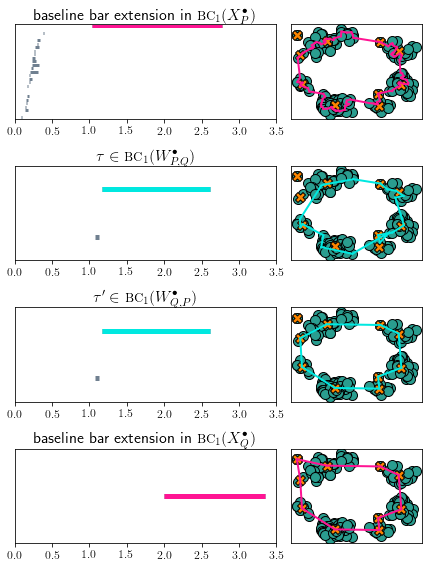

In [157]:
# plot barcodes 
fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (6, 8),
                    gridspec_kw = {"width_ratios": [2,1]})
xleft = 0
xright = 3.5
labelsize = 12
W_color = "#00E8E0" #cyan
VR_color = "#ff1493" #pink


##### PLOT BARCODES #####
### VR_P_barcode ###
# sort and plot barcode
index = np.argsort(barcode_P[:,0]).tolist()
plot_barcode(barcode_P[index,:], ax = ax[0][0], lw = 3, xleft = xleft, xright = xright, labelsize = labelsize, title = r'baseline bar extension in $\textsc{bc}_1(X^\bullet_P)$')
# highlight the bar extension to barcode_P
bar_idx = [index.index(i-1) for i in bar_VR_P]
color_barcode(ax[0][0], barcode_P[index,:], bar_idx = bar_idx, color = VR_color, lw = 3)

### Witness barcode W_PQ###
# sort and plot barcode
index = np.argsort(barcode_W_P[:,0]).tolist()
plot_barcode(barcode_W_P[index,:], ax = ax[1][0], lw = 5,  xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\tau \in \textsc{bc}_1(W^\bullet_{P, Q})$')
# highlight selected bar in Witness barcode
bar_idx = [index.index(i-1) for i in bar_W_PQ]
color_barcode(ax[1][0], barcode_W_P[index,:], bar_idx = bar_idx, color = W_color, lw = 5)

### Witness barcode W_QP###
# sort and plot barcode
index = np.argsort(barcode_W_Q[:,0]).tolist()
plot_barcode(barcode_W_Q[index,:], ax = ax[2][0], lw = 5,  xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\tau^{\prime} \in \textsc{bc}_1(W^\bullet_{Q, P})$')
# highlight selected bar in Witness barcode
bar_idx = [index.index(i-1) for i in bar_W_QP]
color_barcode(ax[2][0], barcode_W_Q[index,:], bar_idx = bar_idx, color = W_color, lw = 5)

### VR_Q_barcode ###
# sort and plot barcode
index = np.argsort(barcode_Q[:,0]).tolist()
plot_barcode(barcode_Q[index,:], ax = ax[3][0], lw = 5,  xleft = xleft, xright = xright, labelsize = labelsize, title = r'baseline bar extension in $\textsc{bc}_1(X^\bullet_Q)$')
# highlight bar extension in barcode_Q
bar_idx = [index.index(i-1) for i in bar_VR_Q]
color_barcode(ax[3][0], barcode_Q[index,:], bar_idx = bar_idx, color = VR_color, lw = 5)


##### PLOT CYCLE REPS #####
### plot cycle_P ###
plot_points(points, centroids, ax[0][1], legend = False)
plot_cycle(cycle_P, ax[0][1], points, linewidth = 2, cycle_color = VR_color)

### plot cycle_W_PQ ###
plot_points(points, centroids, ax[1][1], legend = False)
plot_cycle(cycle_W_PQ, ax[1][1], points, linewidth = 2, cycle_color = W_color)

### plot cycle_W_QP ###
plot_points(points, centroids, ax[2][1], legend = False)
plot_cycle(cycle_W_QP, ax[2][1], centroids, linewidth = 2, cycle_color = W_color)

### plot cycle_Q ###
plot_points(points, centroids, ax[3][1], legend = False)
plot_cycle(cycle_Q, ax[3][1], centroids, linewidth = 2, cycle_color = VR_color)

fig.tight_layout() 
#plt.savefig("figures/clustering_summary.pdf")
plt.show()


# Trefoil knot

In [47]:
# load points 
with h5py.File("data/trefoil_knot/points_new.jld2", "r") as f:
    P = f["trefoil_knot"][()].transpose()
    
with h5py.File("data/trefoil_knot/points_2D.jld", "r") as f:
    P_2D = f["points_2d"][()].transpose()


## (a) plot points in 3D

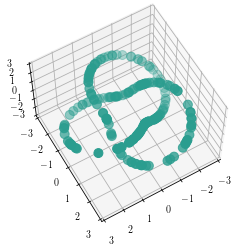

In [48]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(P[:,0], P[:,1], P[:,2], c = color1, s = 80)
ax.set_xlim((-3, 3))
ax.set_ylim((-3, 3))
ax.set_zlim((-3, 3))
ax.view_init(60, 60)
#plt.savefig("figures/trefoil_knot.pdf")
plt.show()

## (b) plot points in 2D

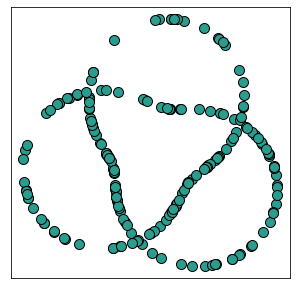

In [49]:
plt.figure(figsize = (5,5))
plt.scatter(P_2D[:,0], P_2D[:,1], c = color1, s = 100, edgecolors = "black")
plt.xticks([])
plt.yticks([])
#plt.savefig("figures/trefoil_knot_2D.pdf")
plt.show()

## (c) barcodes

In [50]:
# load barcodes
with h5py.File("data/trefoil_knot/barcode.jld", "r") as f:
    barcode_orig = np.array(f["barcode_orig"][()]).transpose()
    barcode_pca = np.array(f["barcode_pca"][()]).transpose()

# load bars
with h5py.File("data/trefoil_knot/bars.jld", "r") as f:
    orig_bar = [f["orig_bar"][()]]
    pca_bars = f["pca_bars"][()].tolist()
    epsilon = f["epsilon"][()]

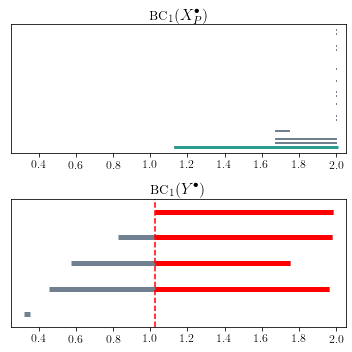

In [63]:
# plot barcodes 
fig, (ax0, ax1) = plt.subplots(nrows = 2, figsize = (5, 5))

xleft = 0.25
xright = 2.05
labelsize = 12

# plot original barcode
index = np.argsort(barcode_orig[:,0]).tolist()
plot_barcode(barcode_orig[index,:], ax = ax0, lw =2, ybottom = -1, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(X^\bullet_P)$')
# highlight the selected bar
bar_idx = [index.index(i-1) for i in orig_bar]
color_barcode(ax0, barcode_orig[index,:], bar_idx = bar_idx, color = color1, lw = 3)

# plot reduced dimension barcode
index = np.argsort(barcode_pca[:,0]).tolist()
plot_barcode(barcode_pca[index,:], ax = ax1, lw = 5, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(Y^\bullet)$')
# highlight extension bar
bar_idx = [index.index(i-1) for i in pca_bars]
color_barcode(ax1, barcode_pca[index,:], bar_idx = bar_idx, color = color1, lw = 5, epsilon = epsilon)
# draw vertical line
ax1.vlines(epsilon, -0.5, len(index), color = "red", linestyle = "dashed")

plt.tight_layout()
#plt.savefig("figures/trefoil_knot_barcodes.pdf")
plt.show()

## (d) cyclereps

In [58]:
# load data
with h5py.File("data/trefoil_knot/cyclereps.jld", "r") as f:
    cycle1 = f["cycle1"][()].tolist()
    cycle2 = f["cycle2"][()].tolist()
    cycle3 = f["cycle3"][()].tolist()
    cycle4 = f["cycle4"][()].tolist()

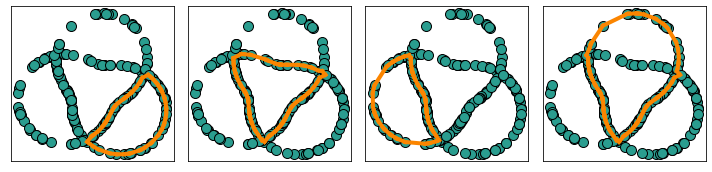

In [61]:
# plot cyclereps
fig, ax = plt.subplots(ncols = 4, figsize = (10,2.5))

# plot cycle 1
ax[0].scatter(P_2D[:,0], P_2D[:,1], c = color1, s = 100, edgecolors = "black")
plot_cycle(cycle1, ax[0], P_2D, linewidth = 4, cycle_color = color2)

# plot cycle 2
ax[1].scatter(P_2D[:,0], P_2D[:,1], c = color1, s = 100, edgecolors = "black")
plot_cycle(cycle2, ax[1], P_2D, linewidth = 4, cycle_color = color2)

# plot cycle 3
ax[2].scatter(P_2D[:,0], P_2D[:,1], c = color1, s = 100, edgecolors = "black")
plot_cycle(cycle3, ax[2], P_2D, linewidth = 4, cycle_color = color2)

# plot cycle 4
ax[3].scatter(P_2D[:,0], P_2D[:,1], c = color1, s = 100, edgecolors = "black")
plot_cycle(cycle4, ax[3], P_2D, linewidth = 4, cycle_color = color2)

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])


fig.tight_layout() 
#plt.savefig("figures/trefoil_knot_cyclerep.pdf")
plt.show()


Plot the highlighted bars and their corresponding cycle reps

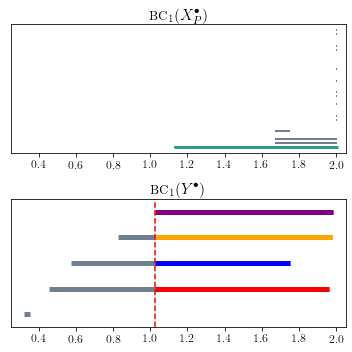

In [70]:
# plot barcodes 
fig, (ax0, ax1) = plt.subplots(nrows = 2, figsize = (5, 5))

xleft = 0.25
xright = 2.05
labelsize = 12

# plot original barcode
index = np.argsort(barcode_orig[:,0]).tolist()
plot_barcode(barcode_orig[index,:], ax = ax0, lw =2, ybottom = -1, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(X^\bullet_P)$')
# highlight the selected bar
bar_idx = [index.index(i-1) for i in orig_bar]
color_barcode(ax0, barcode_orig[index,:], bar_idx = bar_idx, color = color1, lw = 3)

# plot reduced dimension barcode
index = np.argsort(barcode_pca[:,0]).tolist()
plot_barcode(barcode_pca[index,:], ax = ax1, lw = 5, xleft = xleft, xright = xright, labelsize = labelsize, title = r'$\textsc{bc}_1(Y^\bullet)$')

# highlight extension bar 2
bar_idx = [index.index(i-1) for i in [2]]
color_barcode(ax1, barcode_pca[index,:], bar_idx = bar_idx, color = "red", lw = 5, epsilon = epsilon)

# highlight extension bar 3
bar_idx = [index.index(i-1) for i in [3]]
color_barcode(ax1, barcode_pca[index,:], bar_idx = bar_idx, color = "blue", lw = 5, epsilon = epsilon)

# highlight extension bar 4
bar_idx = [index.index(i-1) for i in [4]]
color_barcode(ax1, barcode_pca[index,:], bar_idx = bar_idx, color = "orange", lw = 5, epsilon = epsilon)

# highlight extension bar 5
bar_idx = [index.index(i-1) for i in [5]]
color_barcode(ax1, barcode_pca[index,:], bar_idx = bar_idx, color = "purple", lw = 5, epsilon = epsilon)

# draw vertical line
ax1.vlines(epsilon, -0.5, len(index), color = "red", linestyle = "dashed")

plt.tight_layout()
#plt.savefig("figures/trefoil_knot_barcodes.pdf")
plt.show()

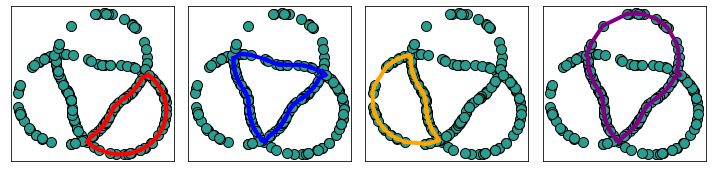

In [71]:
# plot cyclereps
fig, ax = plt.subplots(ncols = 4, figsize = (10,2.5))

# plot cycle 1 (corresponds to bar 2)
ax[0].scatter(P_2D[:,0], P_2D[:,1], c = color1, s = 100, edgecolors = "black")
plot_cycle(cycle1, ax[0], P_2D, linewidth = 4, cycle_color = "red")

# plot cycle 2 (corresponds to bar 3)
ax[1].scatter(P_2D[:,0], P_2D[:,1], c = color1, s = 100, edgecolors = "black")
plot_cycle(cycle2, ax[1], P_2D, linewidth = 4, cycle_color = "blue")

# plot cycle 3 (corresponds to bar 4)
ax[2].scatter(P_2D[:,0], P_2D[:,1], c = color1, s = 100, edgecolors = "black")
plot_cycle(cycle3, ax[2], P_2D, linewidth = 4, cycle_color = "orange")

# plot cycle 4 (corresponds to bar 5)
ax[3].scatter(P_2D[:,0], P_2D[:,1], c = color1, s = 100, edgecolors = "black")
plot_cycle(cycle4, ax[3], P_2D, linewidth = 4, cycle_color = "purple")

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])


fig.tight_layout() 
#plt.savefig("figures/trefoil_knot_cyclerep.pdf")
plt.show()

# Cylinder 

## (a) plot 3D points

In [175]:
with h5py.File("data/dim_reduction/points.jld", "r") as f:
    points = f["points"][()].transpose()
    X_pca = f["PCA"][()]

In [176]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

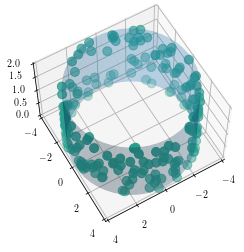

In [177]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(points[:,0], points[:,1], points[:,2], c = color1, s = 80)

Xc,Yc,Zc = data_for_cylinder_along_z(0,0,4,2)
ax.plot_surface(Xc, Yc, Zc, alpha=0.3)

ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))
ax.set_zlim((0, 2))
ax.view_init(60, 60)
#plt.savefig("figures/cylinder_3D.pdf")
plt.show()

## (b) plot 2D points

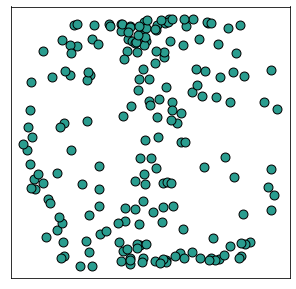

In [178]:
plt.figure(figsize = (5,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c = color1, s = 80, edgecolors = "black")
plt.xticks([])
plt.yticks([])
#plt.savefig("figures/cylinder_2d.pdf")
plt.show()

## (c) plot extension result

In [179]:
# load data
with h5py.File("data/dim_reduction/barcode.jld", "r") as f:
    barcode_X = f["barcode_X"][()].transpose()
    barcode_Y = f["barcode_Y"][()].transpose()
    bar_X = f["bar_X"][()].tolist()
    bar_Y = f["bars_Y"][()].tolist()
    epsilon = f["epsilon"][()]

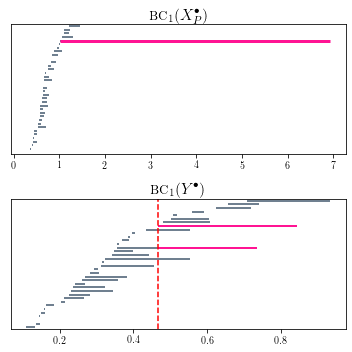

In [180]:
# plot barcodes 
fig, (ax0, ax1) = plt.subplots(nrows = 2, figsize = (5, 5))


# plot original barcode
index = np.argsort(barcode_X[:,0]).tolist()
plot_barcode(barcode_X[index,:], ax = ax0, lw =2, title = r'$\textsc{bc}_1(X^\bullet_P)$')
# highlight the selected bar
bar_idx = [index.index(i-1) for i in bar_X]
color_barcode(ax0, barcode_X[index,:], bar_idx = bar_idx, color = VR_color, lw = 3)

# plot reduced dimension barcode
index = np.argsort(barcode_Y[:,0]).tolist()
plot_barcode(barcode_Y[index,:], ax = ax1, lw = 2,title = r'$\textsc{bc}_1(Y^\bullet)$')
# highlight extension bar
bar_idx = [index.index(i-1) for i in bar_Y]
color_barcode(ax1, barcode_Y[index,:], bar_idx = bar_idx, color = VR_color, lw = 2, epsilon = epsilon)
# draw vertical line
ax1.vlines(epsilon, -0.5, len(index), color = "red", linestyle = "dashed")

plt.tight_layout()
#plt.savefig("figures/cylinder_extension.pdf")
plt.show()

## (d) two dimensional placne on cylinder

In [181]:
# load coefficients for equation of the plane
with h5py.File("data/dim_reduction/equation_plane.jld", "r") as f:
    D = f["D"][()]
    coeff = f["coeff"][()].tolist()

In [182]:
# equation of plane
plane = lambda x, y: (D - coeff[0] * x - coeff[1] * y) / coeff[2]

xx, yy = np.mgrid[-6:6:0.1, -6:6:0.1]
plane_v = np.vectorize(plane) 
zz = plane(xx, yy)

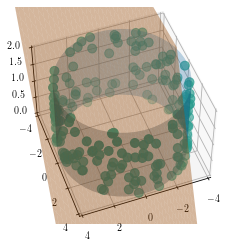

In [183]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plot points
ax.scatter(points[:,0], points[:,1], points[:,2], c = color1, s = 80)

# plot cylinder
Xc,Yc,Zc = data_for_cylinder_along_z(0,0,4,2)
ax.plot_surface(Xc, Yc, Zc, alpha=0.3)

# plot plane
ax.plot_surface(xx, yy, zz, alpha = 0.4)

ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))
ax.set_zlim((0, 2))
ax.view_init(50, 70)

#plt.savefig("figures/cylinder_with_plane.pdf")
plt.show()

I can't seem to make this plot in a pretty way

## (e) cycle rep of baseline bar extension (maybe just use the word cycle extension?)

In [184]:
# load cycle rep
with h5py.File("data/dim_reduction/cyclerep.jld", "r") as f:
    cyclerep = f["cycle"][()].tolist()

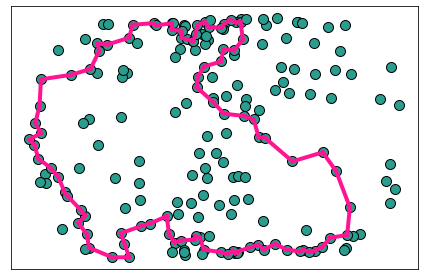

In [185]:
# plot cyclereps
fig, ax = plt.subplots()

ax.scatter(X_pca[:,0], X_pca[:,1], c = color1, s = 100, edgecolors = "black")
plot_cycle(cyclerep, ax, X_pca, linewidth = 4, cycle_color = VR_color)

ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout() 
#plt.savefig("figures/cylinder_extension_cyclerep.pdf")
plt.show()